# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
import sys
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#np.set_printoptions(threshold=sys.maxsize)

from HANKmodel import HANKModelClass

# Setup

In [2]:
#print(model)
model = HANKModelClass(name='baseline')
#model.print_unpack_varlist()

In [3]:
#model = HANKModelClass(name='baseline')
#model.find_ss(do_print=False)
#par = model.par
#ss = model.ss
#path = model.path
#sim = model.sim
#model.test_hh_path()
#model.compute_jacs(do_print=False)
#par.jump_istar = 0.0 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
#model.find_transition_path(do_print=False) #all
#paths = ['pm_N','pi_L','pi_N','p_N','p_L','P_hh','P','Q','Q_check'] #Show all graphs
#lvl_value = ['i','pi_L','pi_N','r','pi','tau','Q','Q_check','P_hh'] #Show all push
#model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=4)

# Step 1: Steady state

In [4]:
model.find_ss(do_print=True)

steady state found in 19.7 secs
 Q   =   0.7235
 P   =   0.8136
 Z_N   =   0.2591
 Z_L   =   0.9977
 M_N   =   0.3121
 M_L   =   0.1242
 N_L   =   0.4029
 N_N   =   0.5469
 HH_ell   =   1.1301
 wage N  =   0.2757
 wage L  =   0.3811
 par.varphi   =   1.0000
 par.beta   =   0.9716
Discrepancy in B =   0.00000000
Discrepancy in C =   0.00000000
Discrepancy in C_L =   0.00000000
Discrepancy in C_N =   0.00000000
Discrepancy in N =  -0.00000000


In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

Distribution graphs:

In [6]:
print(f'Average expenditures share on luxuries (in the data = 51.8%) = {(ss.C_L*ss.Q/(ss.P*ss.C)):8.4f}')
print(f'Average Subsistence share of expenditures (in the data = 22.4%) = {(par.c_bar/(ss.P*ss.C)):8.4f}')
print(f'Lowest income household subsistence share of expenditures (in the data = 43,5%) = {(par.c_bar/(ss.P*np.average(ss.c[0,0,0]))):8.4f}')
print(f'Average expenditures share on necessities for the lowest income households (in the data = 70.5%): = {(np.average(ss.c_N[0,0,0]))/(ss.P*np.average(ss.c[0,0,0])):8.4f}')
print(f'Average expenditures share on necessities (in the data = 48.2%) = {(ss.C_N/(ss.P*ss.C)):8.4f}')
print(f'Average expenditures share on necessities, net of subsistence (in the data = 33.2%) = {(ss.C_HAT_N_hh/(ss.P*ss.C)):8.4f}')
print(f'wage share, necessities production: (in the data = 37.3%) = {(ss.N_N*ss.w_N/(ss.M_N*ss.pm_N+ss.N_N*ss.w_N)):8.4f}')
print(f'wage share, luxuries production: (in the data =69.2%) = {(ss.N_L*ss.w_L/(ss.M_L*ss.pm_L+ss.N_L*ss.w_L)):8.4f}')

Average expenditures share on luxuries (in the data = 51.8%) =   0.5459
Average Subsistence share of expenditures (in the data = 22.4%) =   0.1004
Lowest income household subsistence share of expenditures (in the data = 43,5%) =   0.4974
Average expenditures share on necessities for the lowest income households (in the data = 70.5%): =   0.6950
Average expenditures share on necessities (in the data = 48.2%) =   0.4541
Average expenditures share on necessities, net of subsistence (in the data = 33.2%) =   0.3537
wage share, necessities production: (in the data = 37.3%) =   0.4004
wage share, luxuries production: (in the data =69.2%) =   0.5528


MPCs for different values of Chi and c_bar

In [8]:
'''

model_MPC = model.copy()

c_bar_list = [0.0, 0.025, 0.05, 0.075, 0.10]
chi_list = [0.0, 0.025, 0.05, 0.075, 0.10]

MPC_matrix = np.empty(shape=(len(c_bar_list),len(chi_list)))

for i,c_bar in enumerate(c_bar_list):
    model_MPC.par.c_bar = c_bar
    
    for j,chi in enumerate(chi_list):
        model_MPC.par.chi = chi
        
        model_MPC.find_ss()

        model_MPC.MPC = np.zeros(model_MPC.ss.D.shape)
        m_diff = (1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,1:]-(1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,:-1]
        model_MPC.MPC[:,:,:-1] = (model_MPC.ss.c[:,:,1:]-model_MPC.ss.c[:,:,:-1])/m_diff
        model_MPC.MPC[:,:,-1] = model_MPC.MPC[:,:,-1] # assuming constant MPC at end
        model_MPC.mean_MPC = np.sum(model_MPC.MPC*model_MPC.ss.D)
        model_MPC.mean_MPC_ann = 1-(1-model_MPC.mean_MPC)**4
        MPC_matrix[j,i] = model_MPC.mean_MPC_ann
        print(f'mean MPC - c_bar = {c_bar:.3f}, chi = {chi:.3f} : {model_MPC.mean_MPC:.3f} [annual: {model_MPC.mean_MPC_ann:.3f}]')

df_mpc = pd.DataFrame(MPC_matrix, columns=c_bar_list, index=chi_list)
print(df_mpc.to_latex())

'''

"\n\nmodel_MPC = model.copy()\n\nc_bar_list = [0.0, 0.025, 0.05, 0.075, 0.10]\nchi_list = [0.0, 0.025, 0.05, 0.075, 0.10]\n\nMPC_matrix = np.empty(shape=(len(c_bar_list),len(chi_list)))\n\nfor i,c_bar in enumerate(c_bar_list):\n    model_MPC.par.c_bar = c_bar\n    \n    for j,chi in enumerate(chi_list):\n        model_MPC.par.chi = chi\n        \n        model_MPC.find_ss()\n\n        model_MPC.MPC = np.zeros(model_MPC.ss.D.shape)\n        m_diff = (1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,1:]-(1+model_MPC.ss.r)*model_MPC.par.a_grid[np.newaxis,np.newaxis,:-1]\n        model_MPC.MPC[:,:,:-1] = (model_MPC.ss.c[:,:,1:]-model_MPC.ss.c[:,:,:-1])/m_diff\n        model_MPC.MPC[:,:,-1] = model_MPC.MPC[:,:,-1] # assuming constant MPC at end\n        model_MPC.mean_MPC = np.sum(model_MPC.MPC*model_MPC.ss.D)\n        model_MPC.mean_MPC_ann = 1-(1-model_MPC.mean_MPC)**4\n        MPC_matrix[j,i] = model_MPC.mean_MPC_ann\n        print(f'mean MPC - c_bar = {c_bar:.3f}, chi = {chi

Steady state graphs

mean MPC: 0.074 [annual: 0.265]


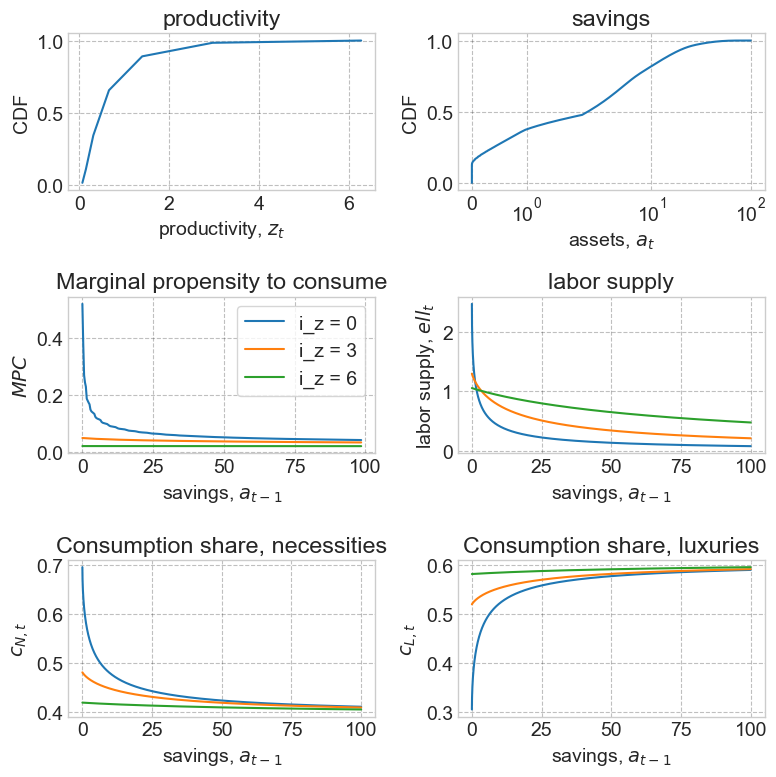

In [22]:
a_max = 500

MPC = np.zeros(ss.D.shape)
m_diff = (1+ss.r)*par.a_grid[np.newaxis,np.newaxis,1:]-(1+model.ss.r)*par.a_grid[np.newaxis,np.newaxis,:-1]
MPC[:,:,:-1] = (ss.c[:,:,1:]-ss.c[:,:,:-1])/m_diff
MPC[:,:,-1] = MPC[:,:,-1] # assuming constant MPC at end
mean_MPC = np.sum(MPC*ss.D)
mean_MPC_ann = 1-(1-mean_MPC)**4
print(f'mean MPC: {mean_MPC:.3f} [annual: {mean_MPC_ann:.3f}]')

fig = plt.figure(figsize=(8,8),dpi=100)

# a. income
ax = fig.add_subplot(3,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(3,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# c. MPC
I = par.a_grid < 1

ax = fig.add_subplot(3,2,3)
ax.set_title(f'Marginal propensity to consume')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I]*100,MPC[0,i_z,I],label=f'i_z = {i_z}')
ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$MPC$')


# D. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(3,2,4)
ax.set_title(f'labor supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $ell_{t}$')


# a. necessity consumption share
I = par.a_grid < a_max
ax = fig.add_subplot(3,2,5)
ax.set_title(f'Consumption share, necessities')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c_N[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')
#ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{N,t}$')

# a. luxury consumption share
I = par.a_grid < a_max

ax = fig.add_subplot(3,2,6)
ax.set_title(f'Consumption share, luxuries')
for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.Q*ss.c_L[0,i_z,I]/(ss.P*ss.c[0,i_z,I]),label=f'i_z = {i_z}')

#ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('$c_{L,t}$')

fig.tight_layout()

# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.3 secs
household problem simulated along transition in 0.1 secs



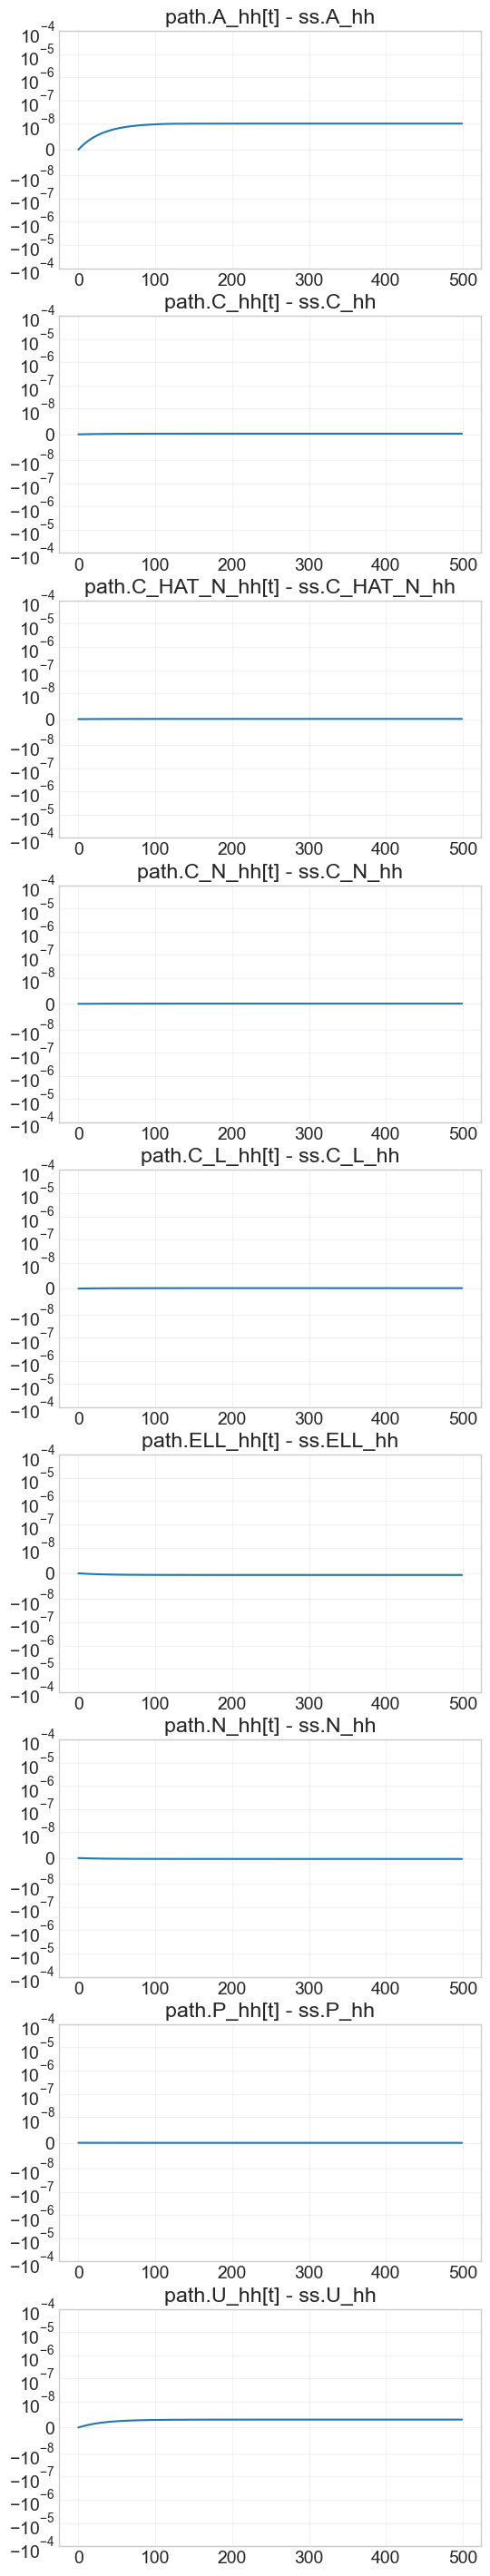

In [52]:
model.test_hh_path()

**Full transition path:**

In [53]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C              : t0 =  0.0e+00, max abs.  0.0e+00
C_N            : t0 =  0.0e+00, max abs.  0.0e+00
C_L            : t0 =  0.0e+00, max abs.  0.0e+00
d_N            : t0 =  0.0e+00, max abs.  0.0e+00
d_L            : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 = -6.9e-18, max abs.  6.9e-18
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 =  0.0e+00, max abs.  0.0e+00
N_N            : t0 =  0.0e+00, max abs.  0.0e+00
N_L            : t0 =  0.0e+00, max abs.  0.0e+00
M_N            : t0 =  0.0e+00, max abs.  0.0e+00
M_L            : t0 =  0.0e+00, max abs.  0.0e+00
pm_L           : t0 =  0.0e+00, max abs.  0.0e+00
pm_N           : t0 =  0.0e+00, max abs.  0.0e+00
p_N            : t0 =  0.0e+00, max abs.  0.0e+00
p_L            : t0

In [54]:
model.compute_jacs(do_print=True)
#model.test_jacs(s_list=[50,100,150])

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for P               in 0.6 secs
curly_Y and curly_D calculated for Q               in 0.6 secs
curly_Y and curly_D calculated for d_L             in 0.6 secs
curly_Y and curly_D calculated for d_N             in 0.7 secs
curly_Y and curly_D calculated for p_L             in 0.6 secs
curly_Y and curly_D calculated for p_N             in 0.6 secs
curly_Y and curly_D calculated for r               in 0.6 secs
curly_Y and curly_D calculated for tau             in 0.6 secs
curly_Y and curly_D calculated for w_N             in 0.6 secs
curly_E calculated in 0.5 secs
builiding blocks combined in 1.0 secs
household Jacobian computed in 6.9 secs

full Jacobians:
full Jacobian to unknowns computed in 18.5 secs [in evaluate_path(): 16.6 secs]
full Jacobian to shocks computed in 3.9 secs [in evaluate_path(): 2.9 secs]


# Step 3a: Find non-linear transition path

## Plot transitions

## Find transition path 1 - Monetary Policy shock

In [55]:
par.jump_istar = 0.0025 # 25 BP Monetary policy shock
par.jump_pm_N     = 0.0 # cost push shock
model.find_transition_path(do_print=False) #all

### shocks ###


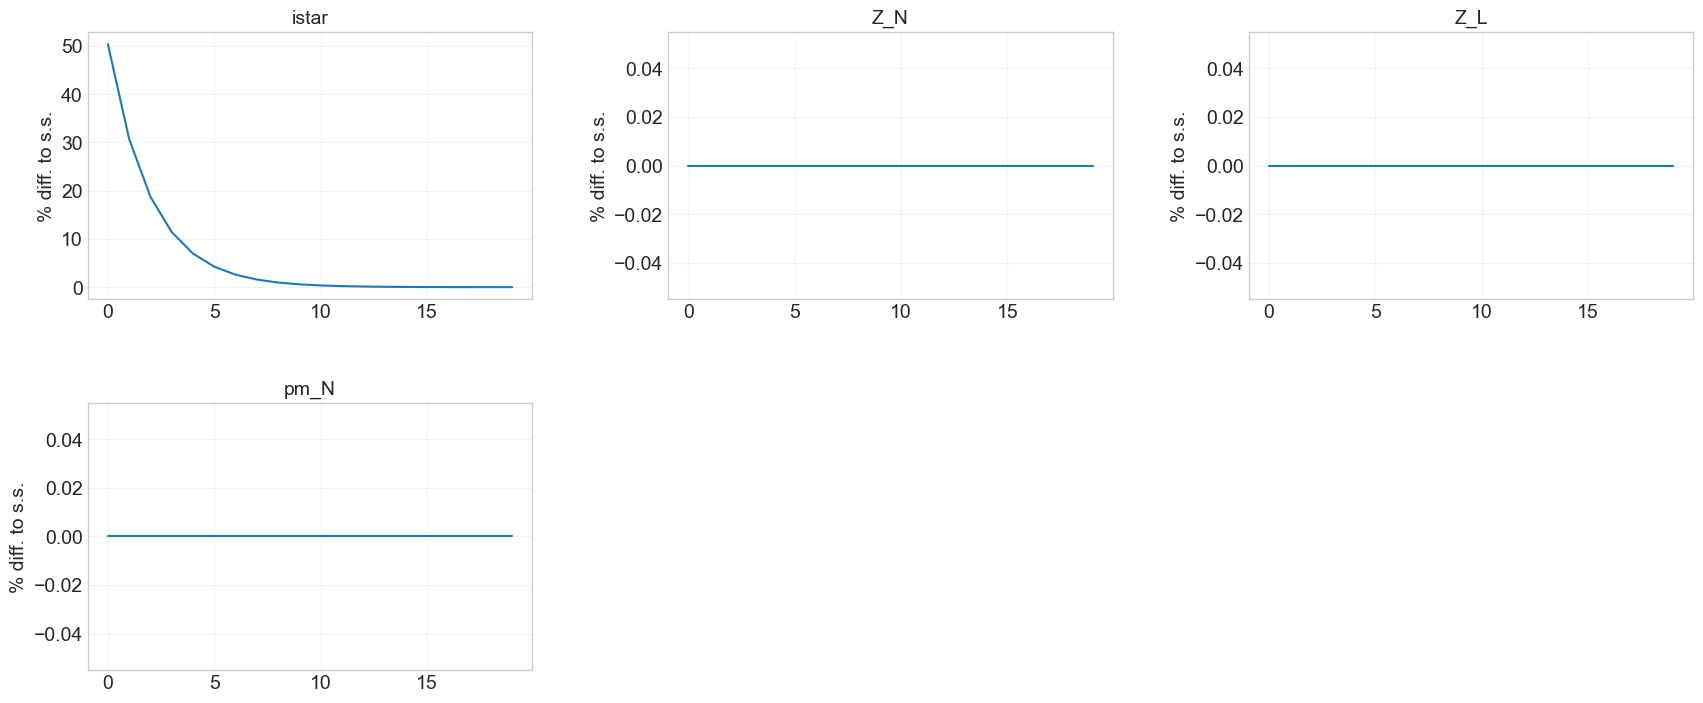


### varnames ###


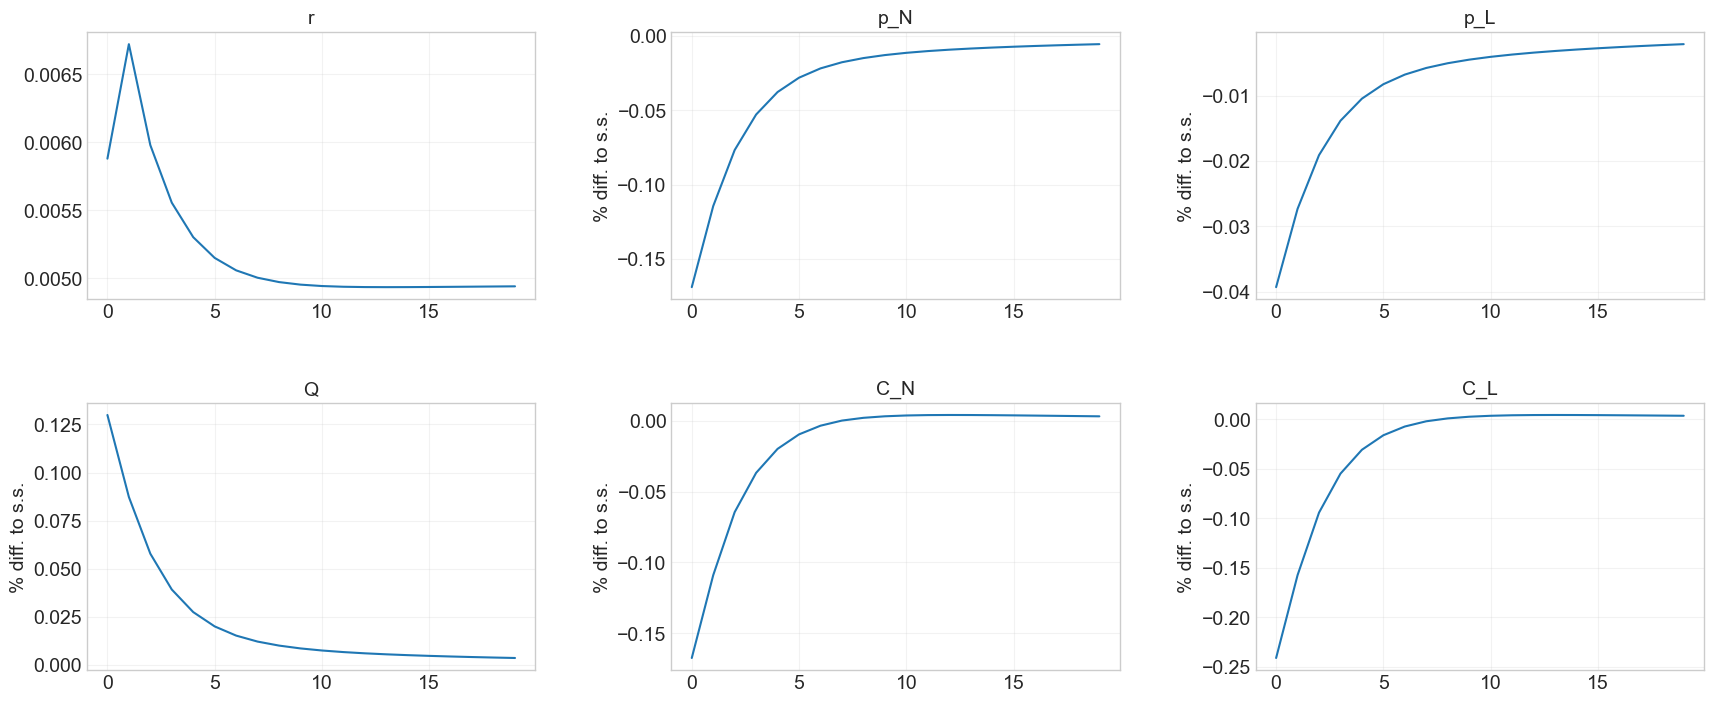


### tagets ###


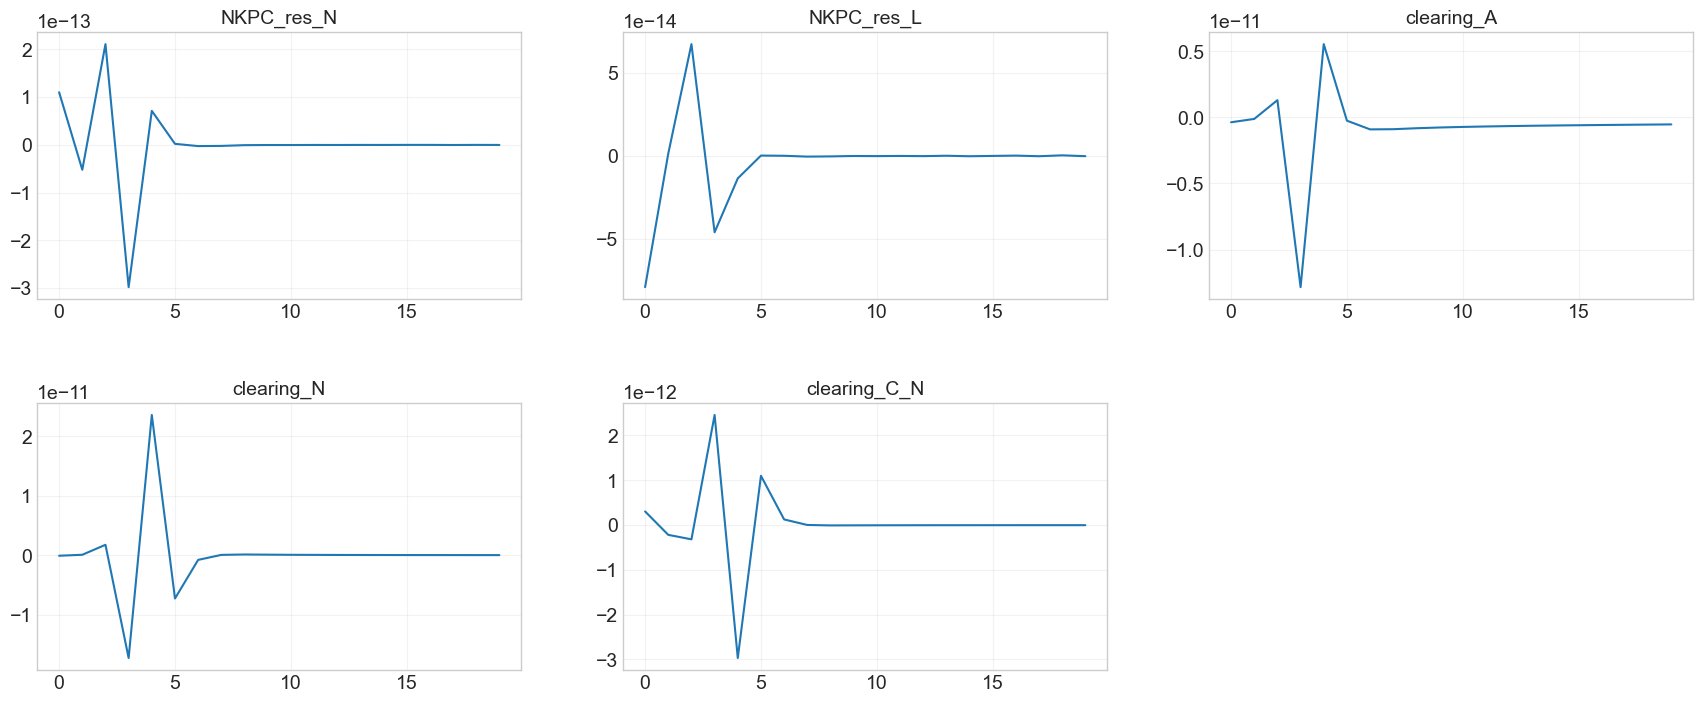

In [56]:
paths_main = ['r','p_N','p_L','Q','C_N','C_L'] #Show main
model.show_IRFs(paths_main,lvl_value=lvl_value,T_max=20,ncols=3)

### shocks ###


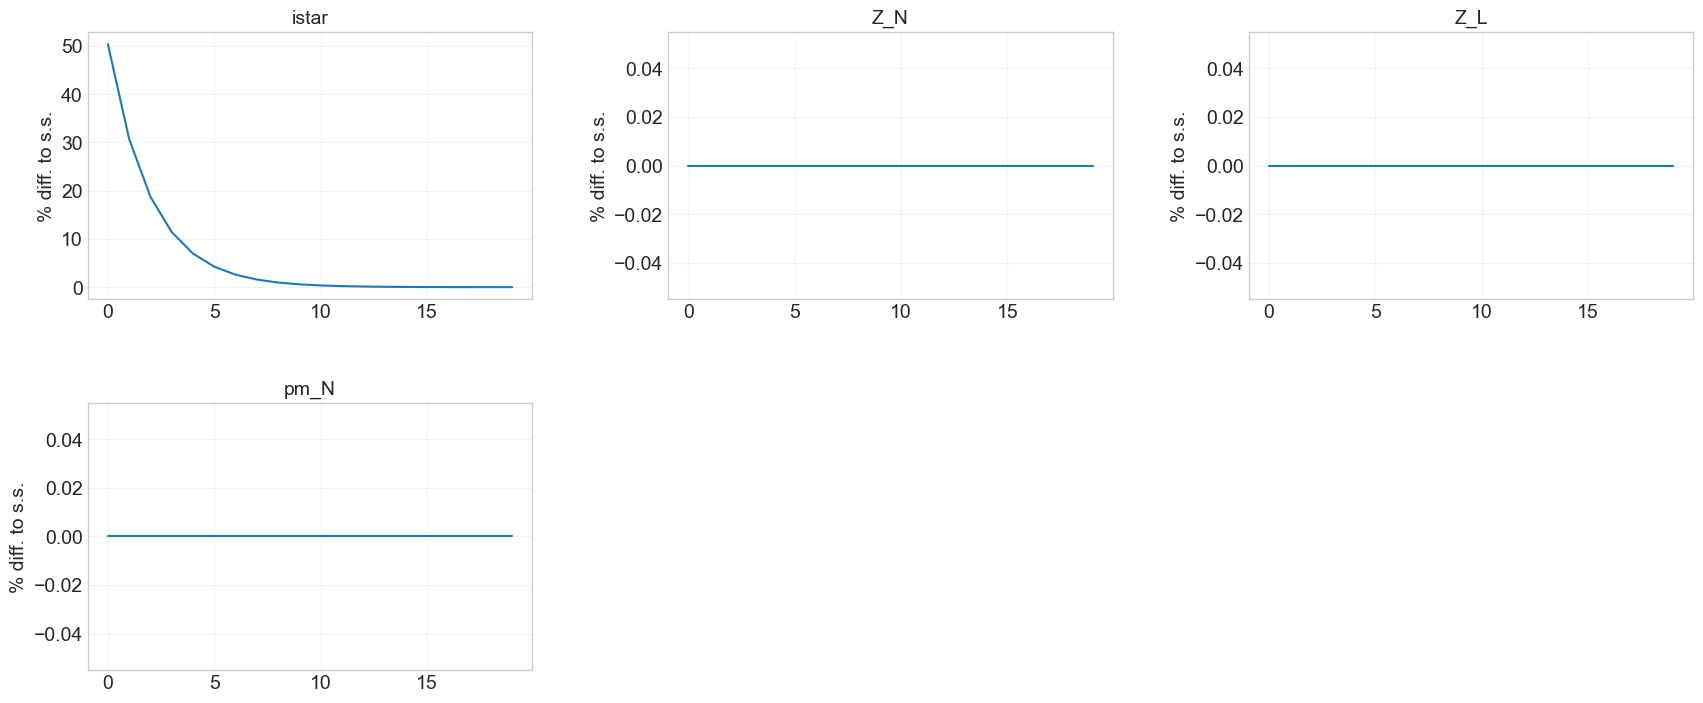


### varnames ###


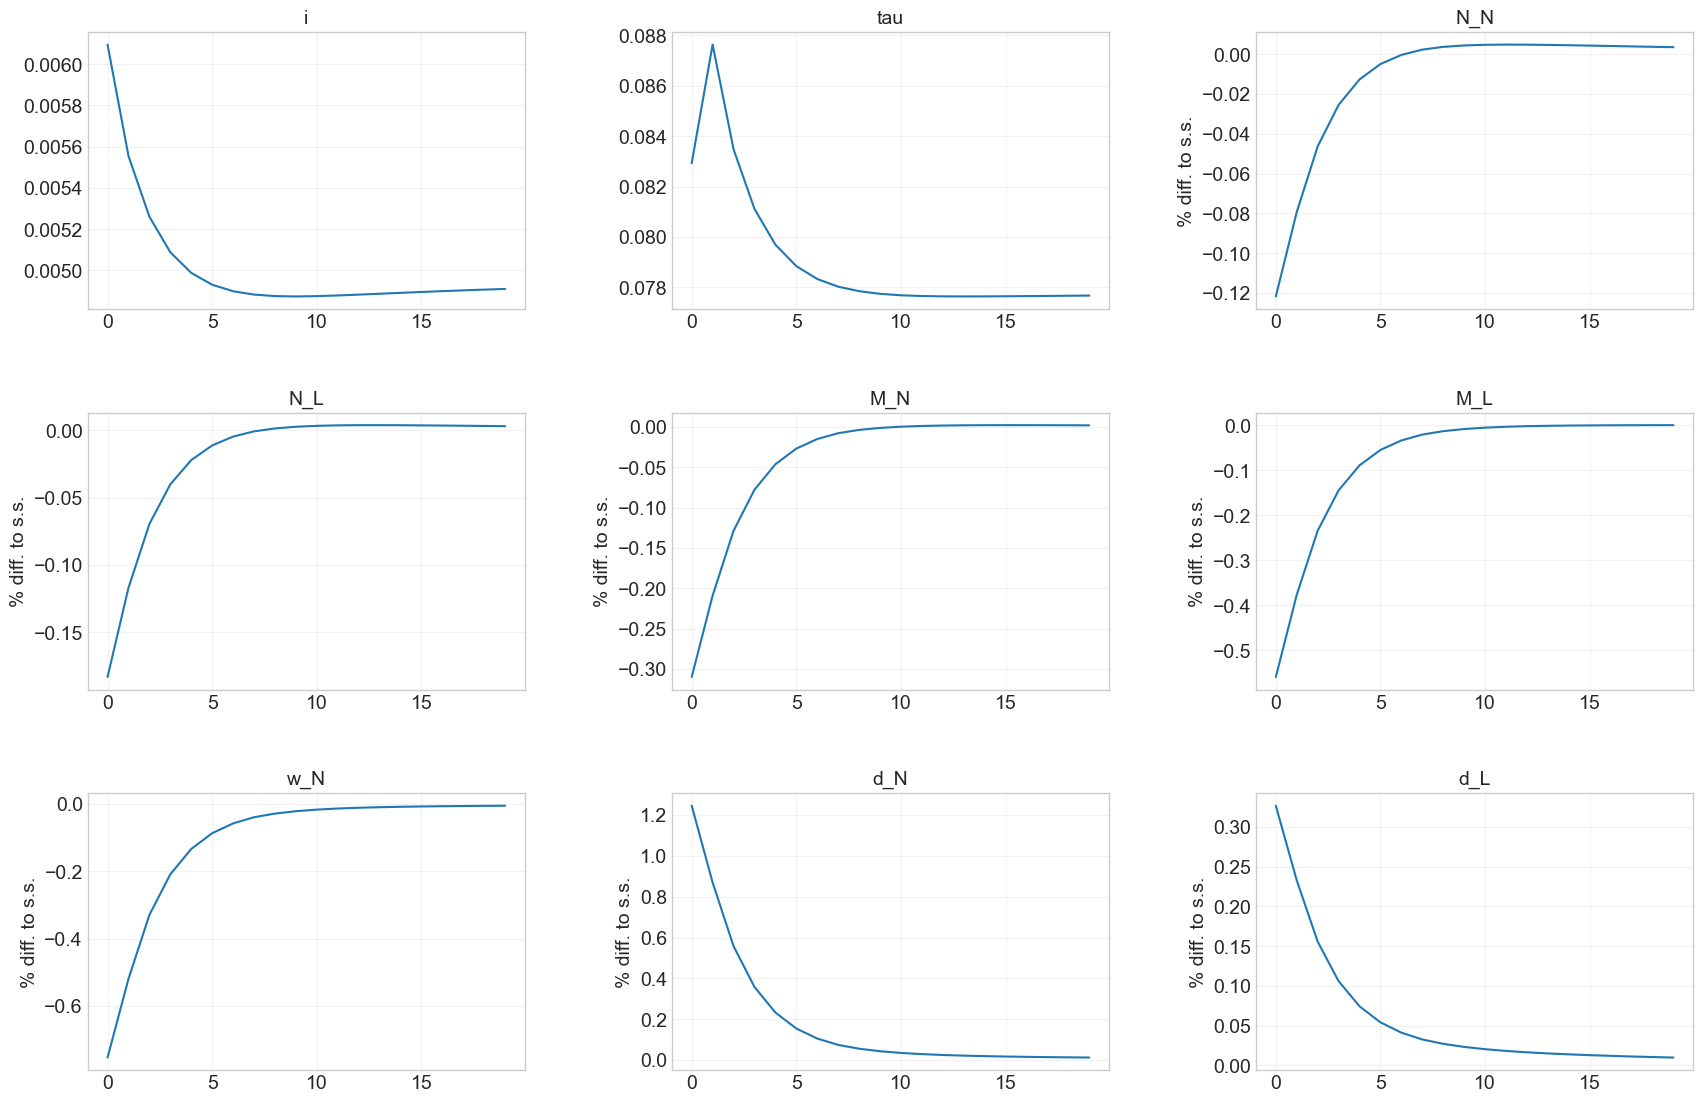


### tagets ###


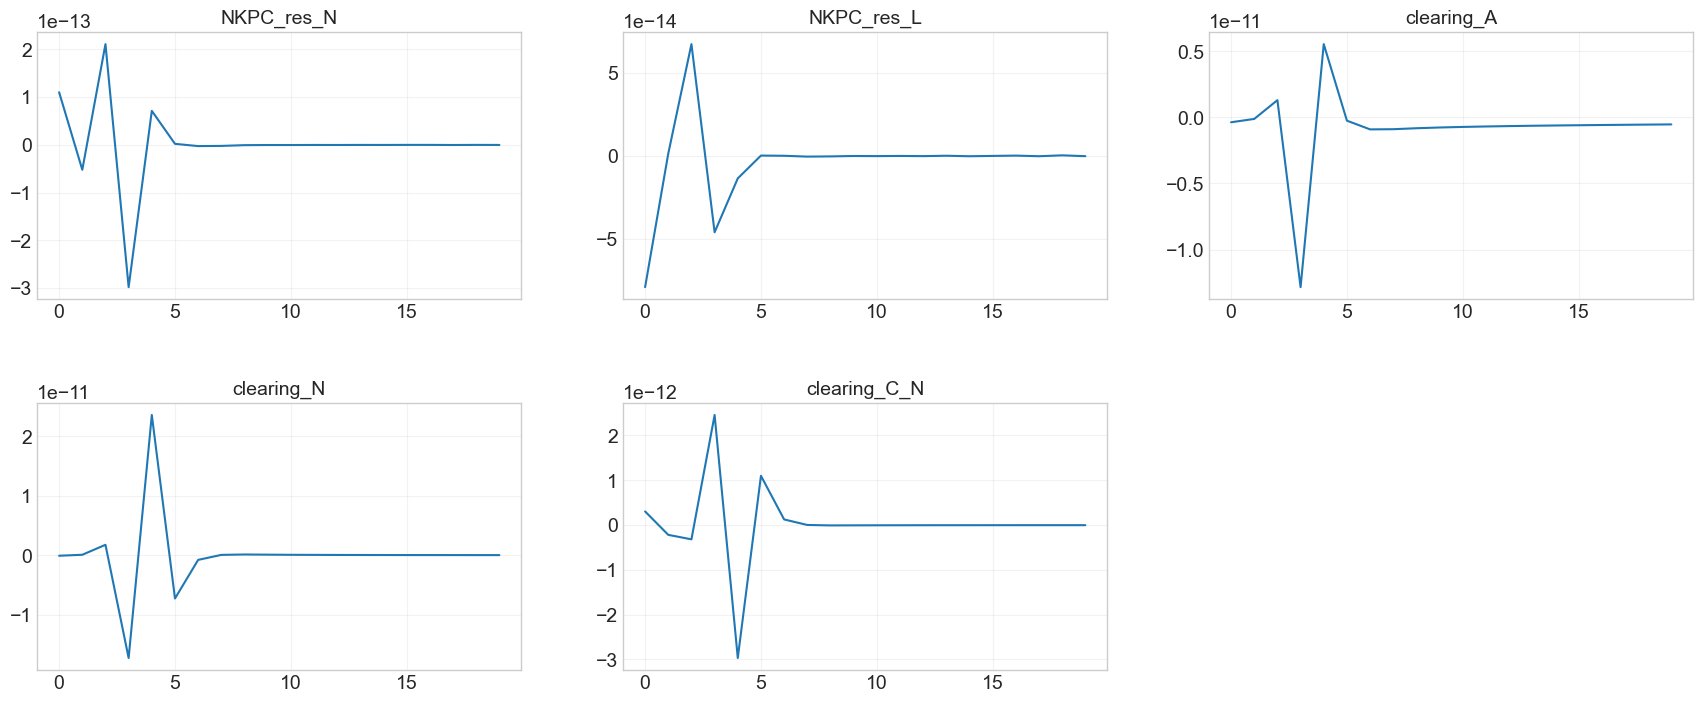

In [57]:
paths_appendix = ['i','tau','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show appendix
model.show_IRFs(paths_appendix,lvl_value=lvl_value,T_max=20,ncols=3)

Overall Consumption decomposition: Monetary Policy Shock

['Direct effects', 'r']

['Price effects', 'Q', 'P', 'p_L', 'p_N']

['Income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['w_N', 'd_N', 'd_L', 'tau']

None

all



Text(0, 0.5, '% diff to s.s.')

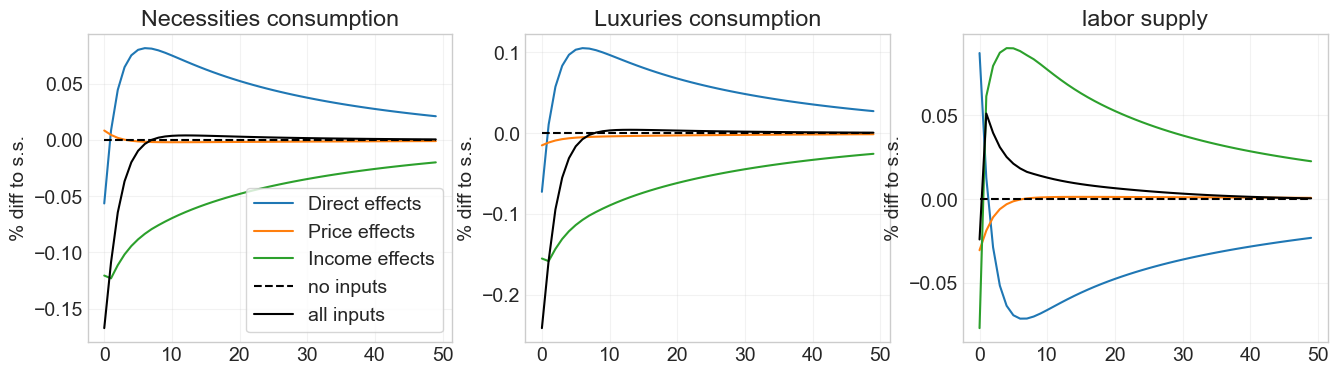

In [58]:
T_max = 50

fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


Individual effects - consumption decomposition, MP shock

r

Q

P

p_L

p_N

N

w_N

d_N

d_L

tau

None

all

r

Q

P

p_L

p_N

N

w_N

d_N

d_L

tau

None

all

r

Q

P

p_L

p_N

N

w_N

d_N

d_L

tau

None

all



Text(0, 0.5, '% diff to s.s.')

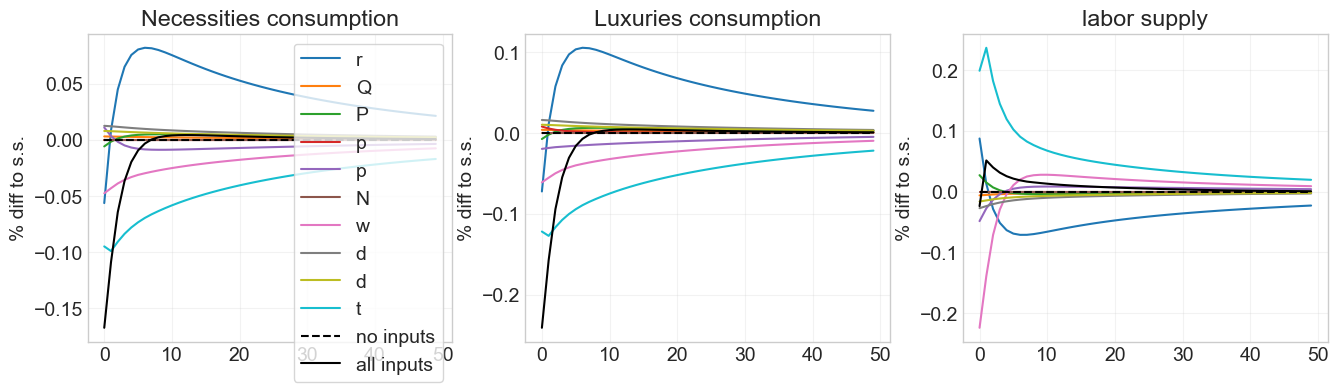

In [59]:
T_max = 50

fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in ['r','Q','P','p_L','p_N','N','w_N','d_N','d_L','tau',None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in ['r','Q','P','p_L','p_N','N','w_N','d_N','d_L','tau',None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in ['r','Q','P','p_L','p_N','N','w_N','d_N','d_L','tau',None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


MP shock - effects on consumption and labor by asset holdings

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['Direct effects', 'r']

['Price effects', 'Q', 'P', 'p_L', 'p_N']

['Income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all



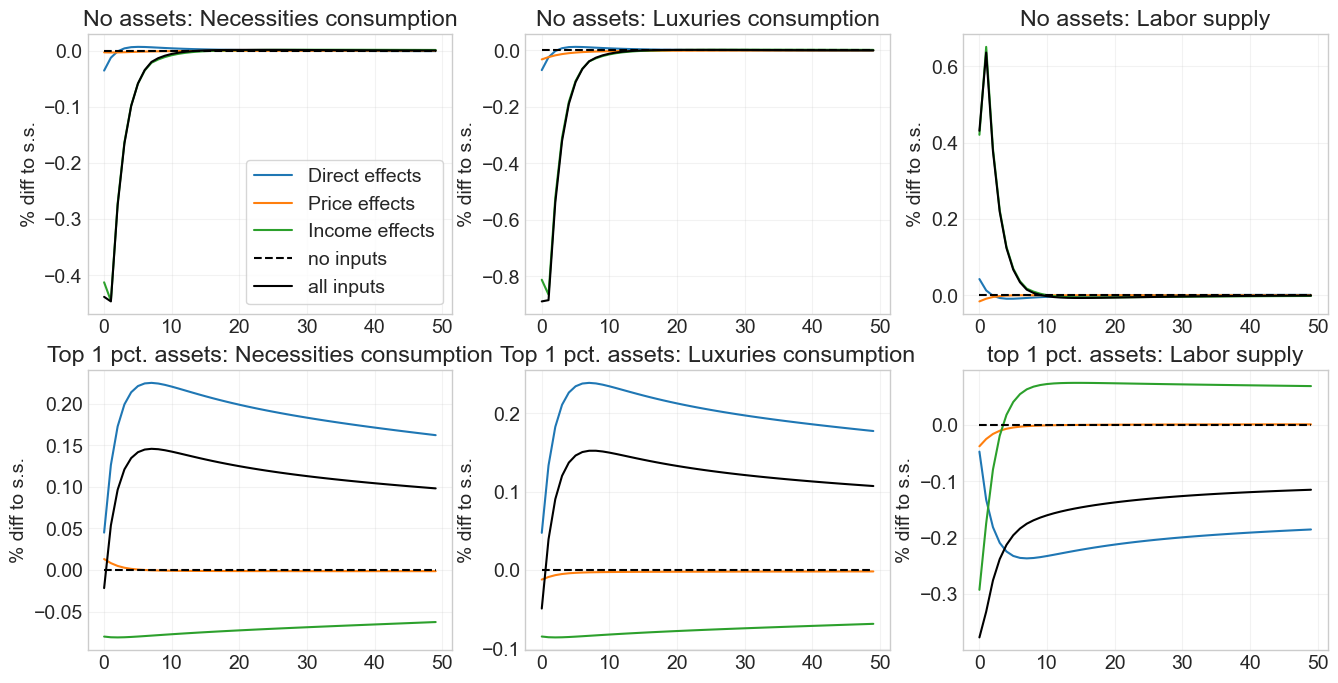

In [60]:
par.jump_istar = 0.0025 # MP shock removed
#par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all



fig = plt.figure(figsize=(16,8),dpi=100)
### FIRST THE POOR WITHOUT ASSETS ### 

### LUXURIES ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(2,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.C_L_hh[0,:50]-path_alt_ss.C_L_hh[0,:50])/path_alt_ss.C_L_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('No assets: Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

### NECESSITIES ###
ax = fig.add_subplot(2,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.C_N_hh[0,:50]-path_alt_ss.C_N_hh[0,:50])/path_alt_ss.C_N_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('No assets: Necessities consumption')        
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);


### LABOR SUPPLY ###
ax = fig.add_subplot(2,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.ELL_hh[0,:50]-path_alt_ss.ELL_hh[0,:50])/path_alt_ss.ELL_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('No assets: Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

Dbeg = ss.Dbeg.copy()

### RICHEST ###

### LUXURIES ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(2,3,5)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.C_L_hh[0,:50]-path_alt_ss.C_L_hh[0,:50])/path_alt_ss.C_L_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Top 1 pct. assets: Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

### NECESSITIES ###

ax = fig.add_subplot(2,3,4)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.C_N_hh[0,:50]-path_alt_ss.C_N_hh[0,:50])/path_alt_ss.C_N_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Top 1 pct. assets: Necessities consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);
### LABOR SUPPLY ###

ax = fig.add_subplot(2,3,6)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.ELL_hh[0,:50]-path_alt_ss.ELL_hh[0,:50])/path_alt_ss.ELL_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('top 1 pct. assets: Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

#ax.legend(frameon=True);
Dbeg = ss.Dbeg.copy()


## Find transition path 2 - cost push shock

In [61]:
par.jump_istar = 0.0 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
model.find_transition_path(do_print=False) #all
paths = ['pm_N','P_hh','r','pi_L','pi_N','Q','C_N','C_L','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show all graphs
paths_prices = ['pm_N','P_hh','r','pi_L','pi_N','Q'] #Show pricing graphs
paths_hh =['C_N','C_L','N_N','N_L','M_N','M_L','w_N','d_N','d_L']
lvl_value = ['i','pi_L','pi_N','r','pi','tau'] #Show all push

### shocks ###


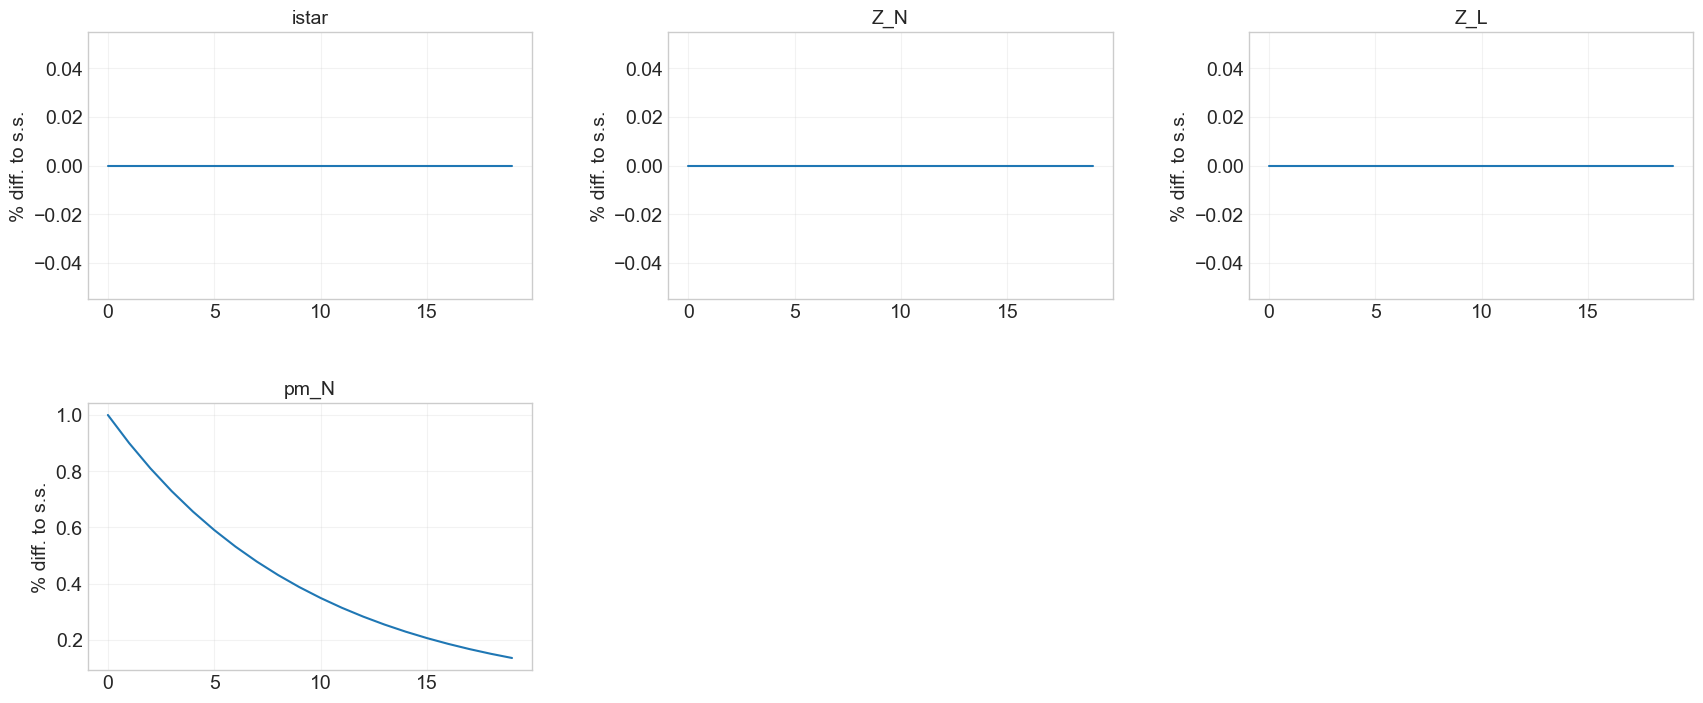


### varnames ###


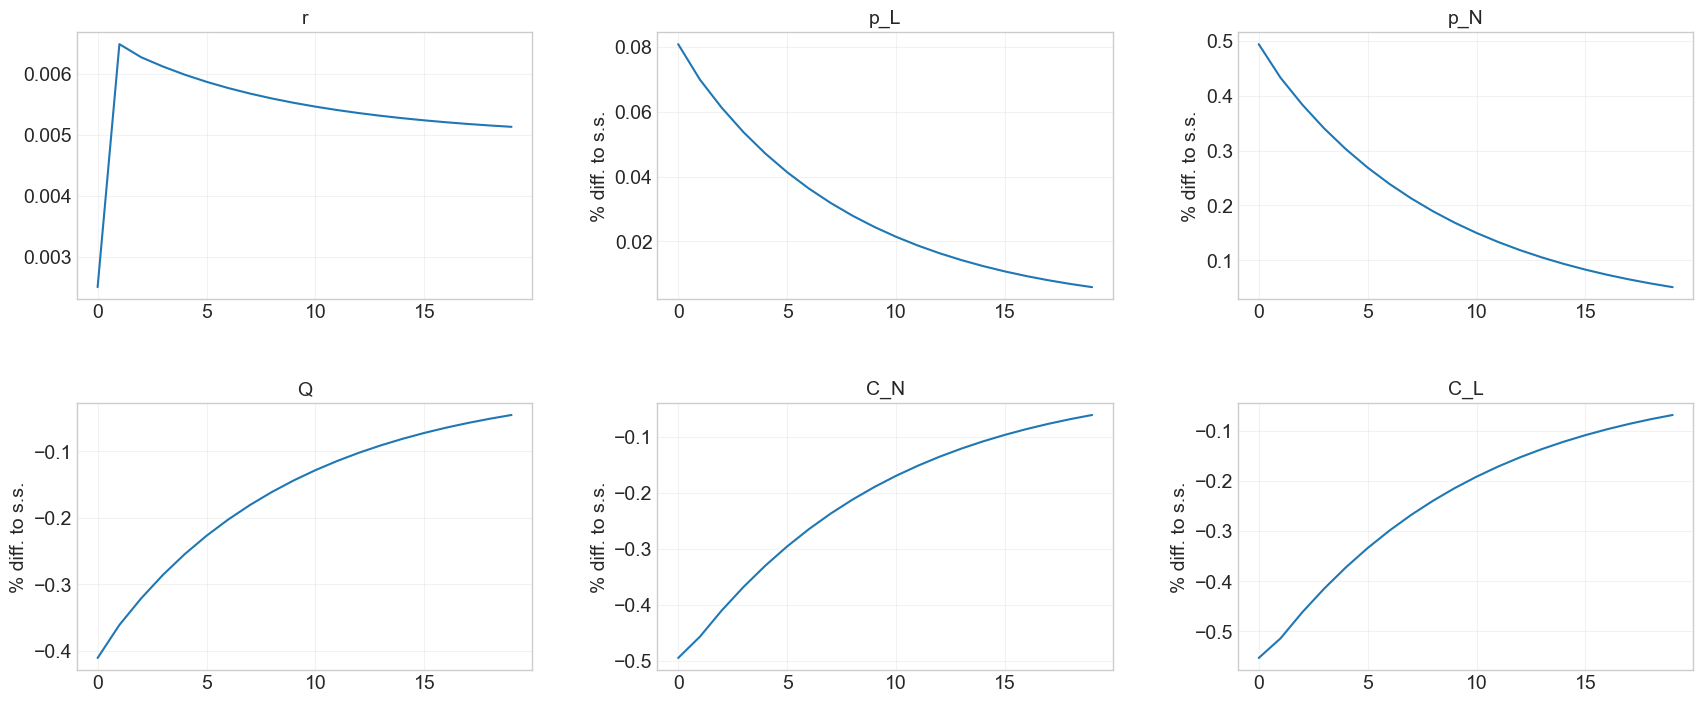


### tagets ###


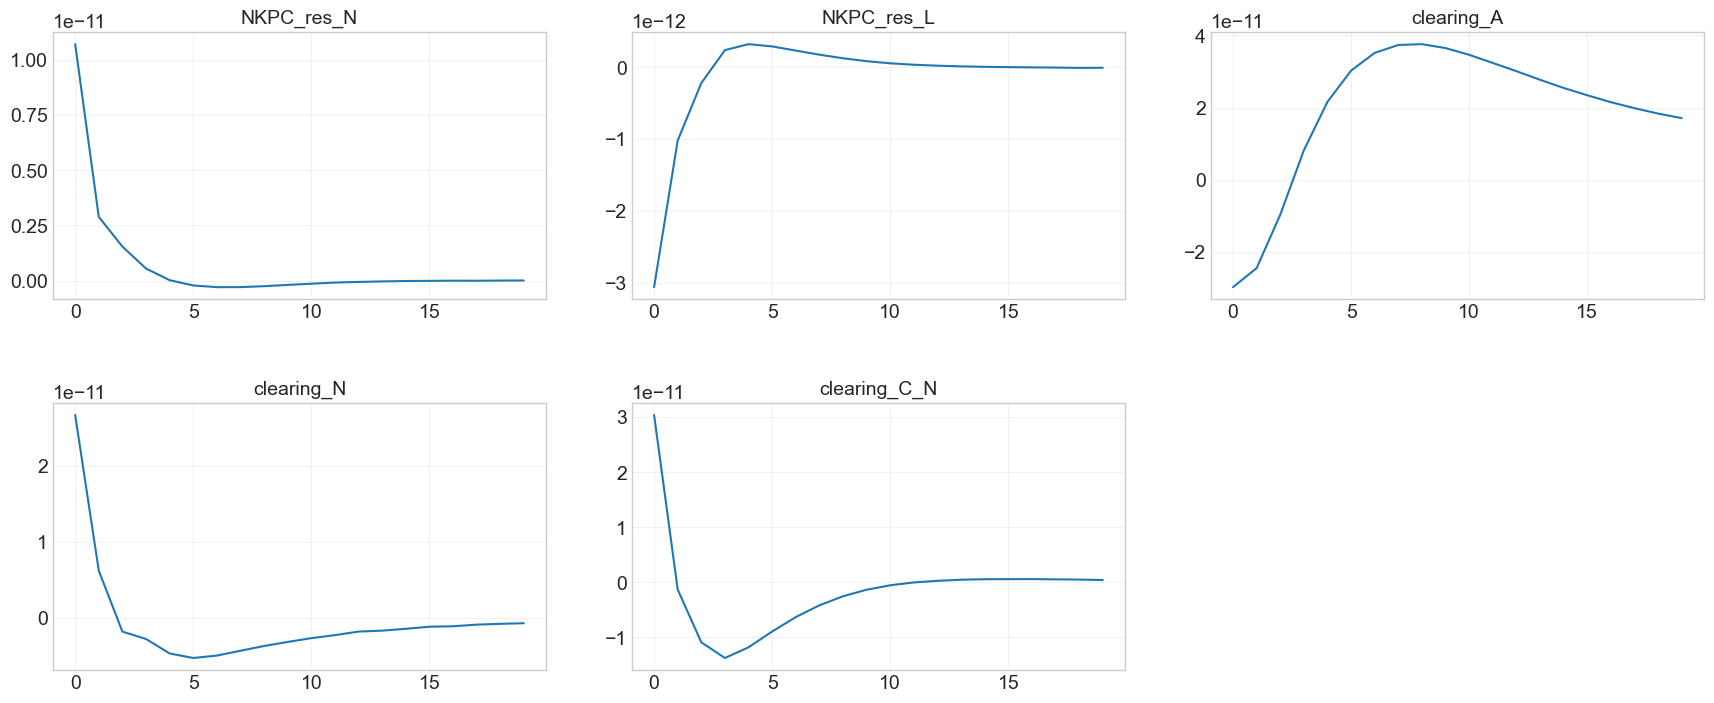

In [62]:
paths_main = ['r','p_L','p_N','Q','C_N','C_L'] #Show main
model.show_IRFs(paths_main,lvl_value=lvl_value,T_max=20,ncols=3)

### shocks ###


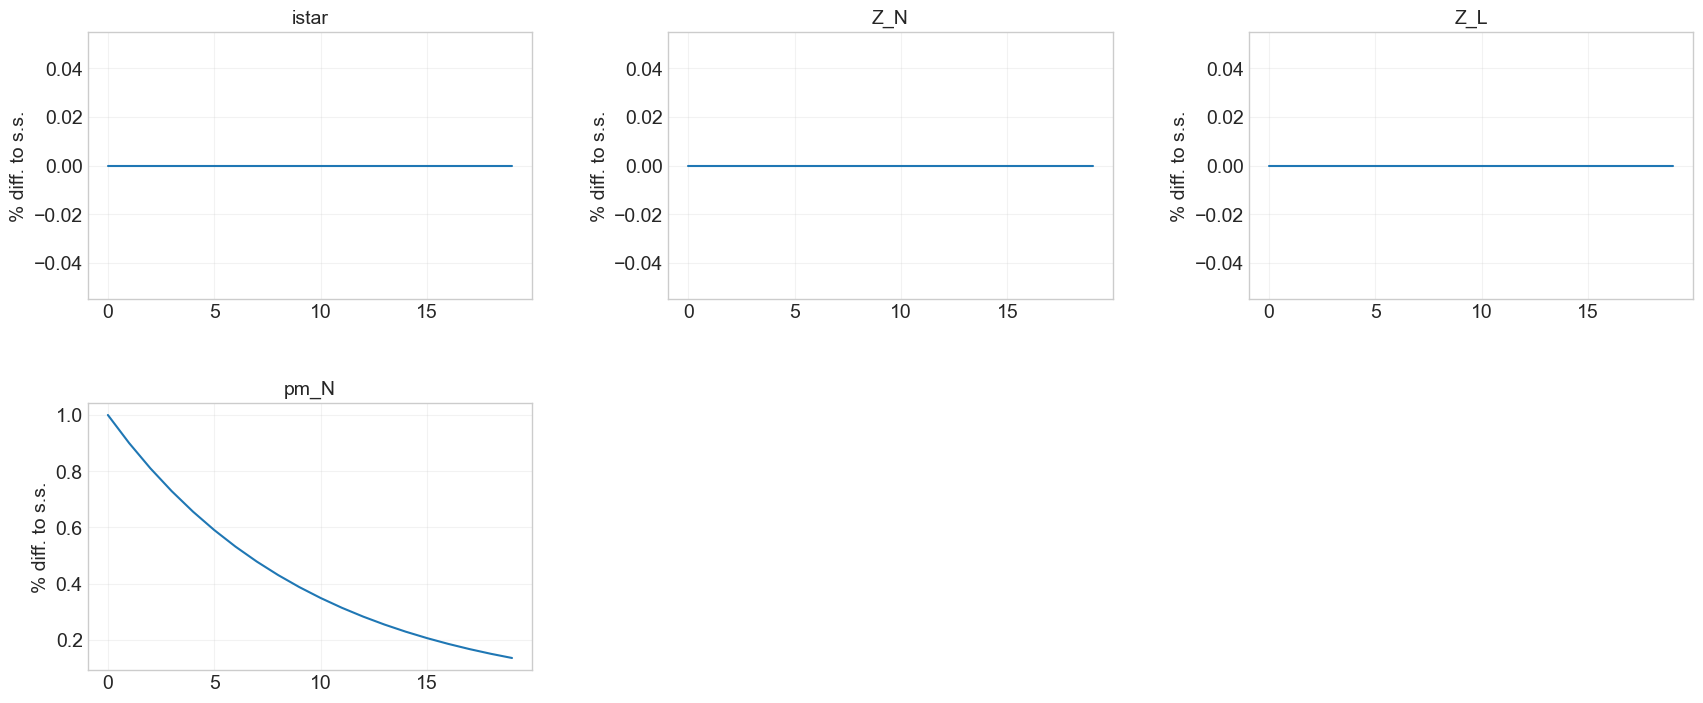


### varnames ###


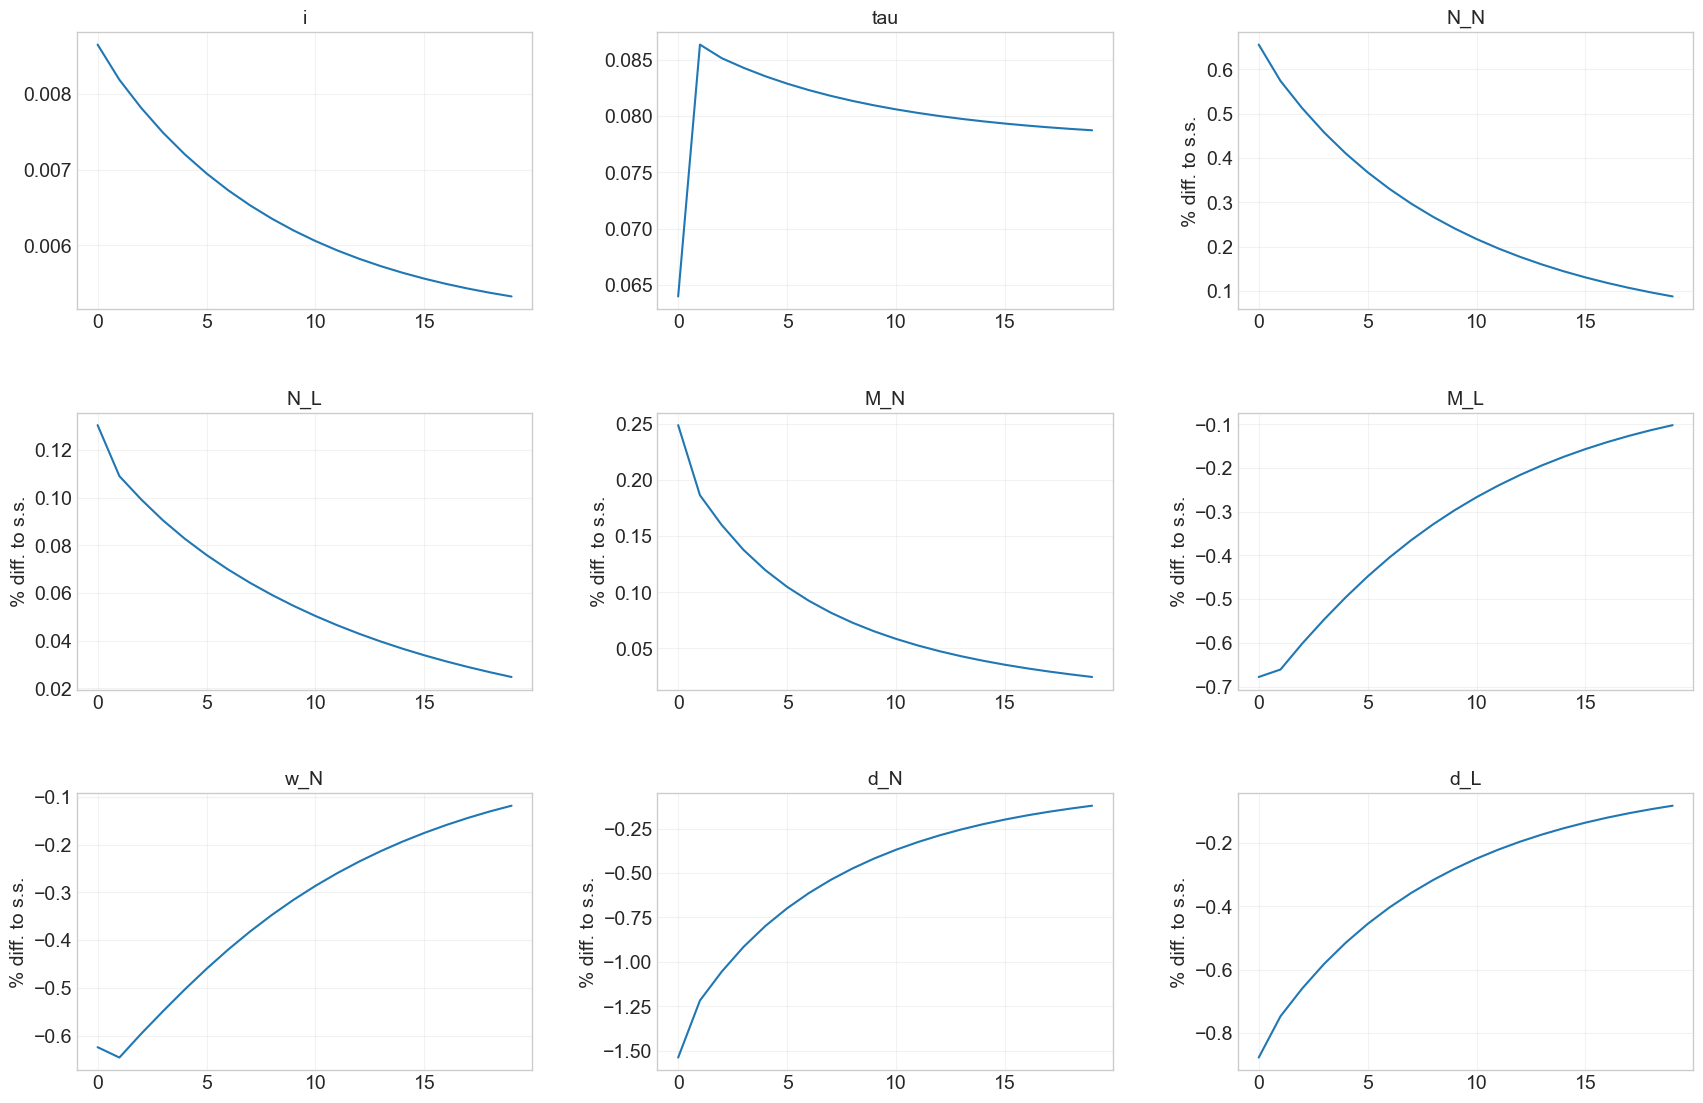


### tagets ###


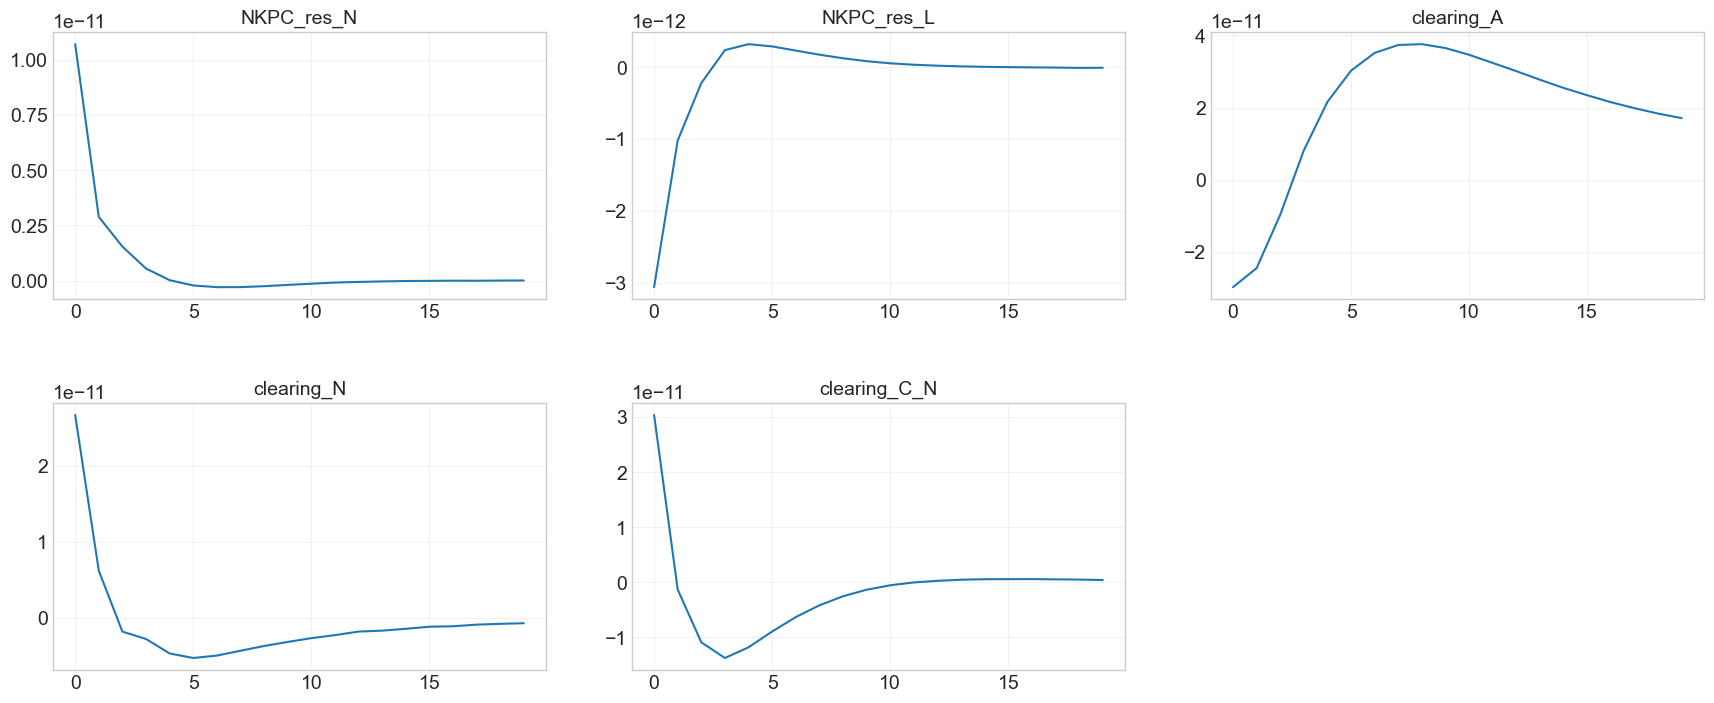

In [63]:
paths_appendix = ['i','tau','N_N','N_L','M_N','M_L','w_N','d_N','d_L'] #Show appendix
model.show_IRFs(paths_appendix,lvl_value=lvl_value,T_max=20,ncols=3)

Consumption decomposition, cost push shock

['Direct effects', 'r']

['Price effects', 'Q', 'P', 'p_L', 'p_N']

['Income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all



Text(0, 0.5, '% diff to s.s.')

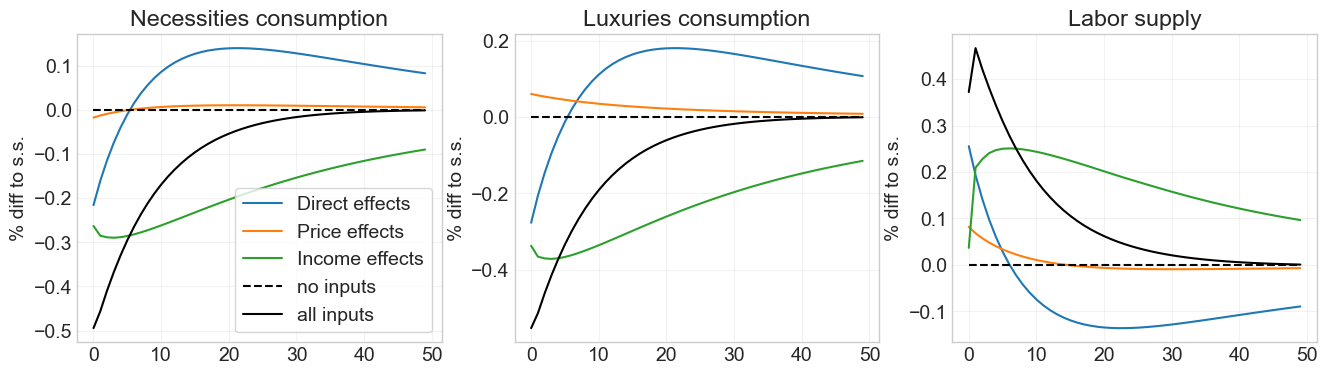

In [64]:
T_max = 50

fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Labor supply')        
ax.set_ylabel('% diff to s.s.')

Cost push shock decompition - individual effects

r

Q

P

p_L

p_N

N

w_N

d_N

d_L

tau

None

all

r

Q

P

p_L

p_N

N

w_N

d_N

d_L

tau

None

all

r

Q

P

p_L

p_N

N

w_N

d_N

d_L

tau

None

all



Text(0, 0.5, '% diff to s.s.')

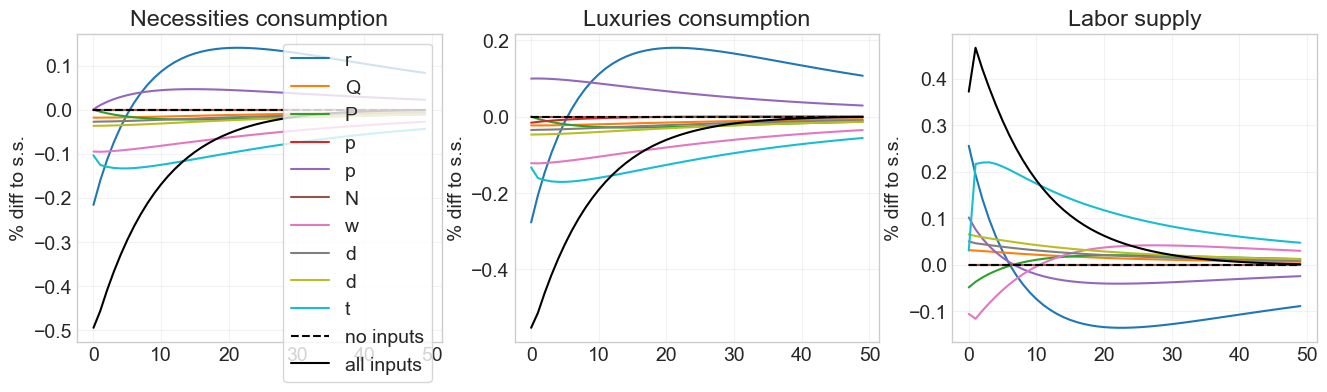

In [65]:
T_max = 50

fig = plt.figure(figsize=(16,4),dpi=100)

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in ['r','Q','P','p_L','p_N','N','w_N','d_N','d_L','tau',None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_N_hh[0,:50]/ss.C_N_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Necessities consumption')    
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in ['r','Q','P','p_L','p_N','N','w_N','d_N','d_L','tau',None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.C_L_hh[0,:50]/ss.C_L_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in ['r','Q','P','p_L','p_N','N','w_N','d_N','d_L','tau',None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=False,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.ELL_hh[0,:50]/ss.ELL_hh-1)*100,ls=ls,color=color,label=label);
ax.set_title('Labor supply')        
ax.set_ylabel('% diff to s.s.')

Cost push shock, effects on consumption and labor by asset holdings

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['Direct effects', 'r']

['Price effects', 'Q', 'P', 'p_L', 'p_N']

['Income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all



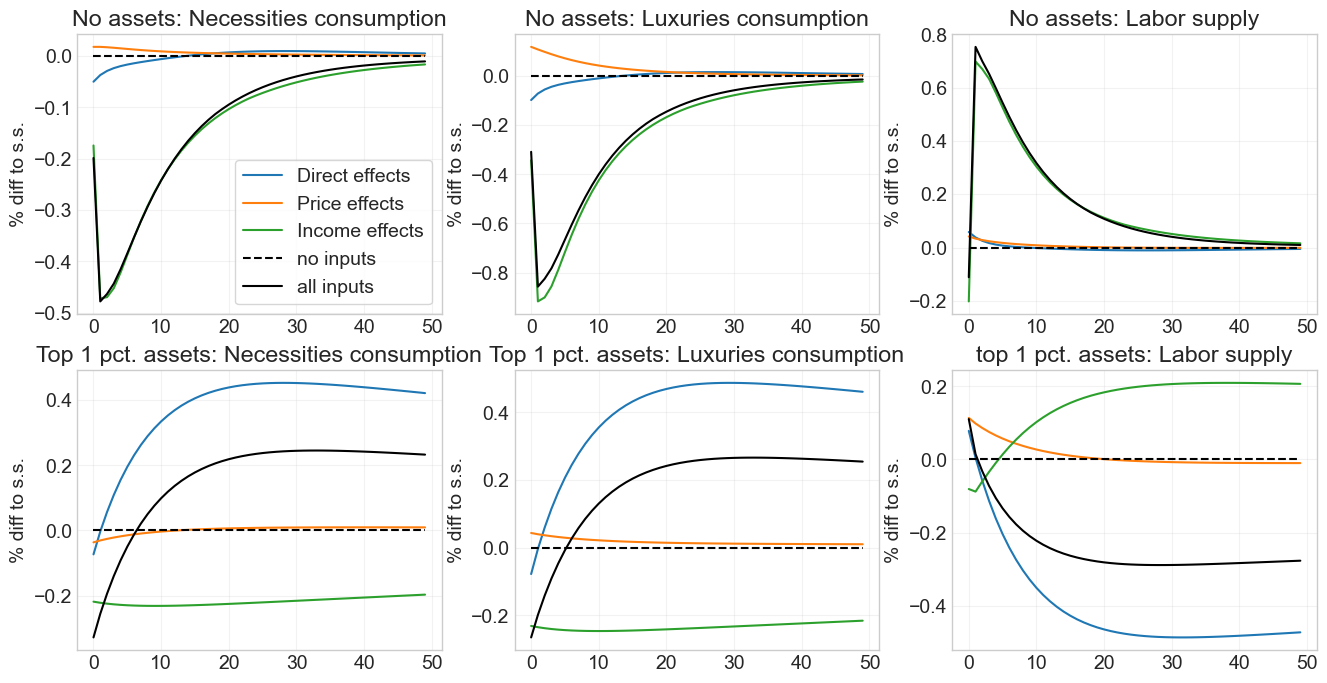

In [66]:
par.jump_istar = 0.00 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
#par.jump_pm_N     = 0.0 # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all



fig = plt.figure(figsize=(16,8),dpi=100)
### FIRST THE POOR WITHOUT ASSETS ### 

### LUXURIES ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(2,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.C_L_hh[0,:50]-path_alt_ss.C_L_hh[0,:50])/path_alt_ss.C_L_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('No assets: Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

### NECESSITIES ###

ax = fig.add_subplot(2,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.C_N_hh[0,:50]-path_alt_ss.C_N_hh[0,:50])/path_alt_ss.C_N_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('No assets: Necessities consumption')        
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);


### LABOR SUPPLY ###
ax = fig.add_subplot(2,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.ELL_hh[0,:50]-path_alt_ss.ELL_hh[0,:50])/path_alt_ss.ELL_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('No assets: Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

Dbeg = ss.Dbeg.copy()

### RICHEST ###

### LUXURIES ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(2,3,5)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.C_L_hh[0,:50]-path_alt_ss.C_L_hh[0,:50])/path_alt_ss.C_L_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Top 1 pct. assets: Luxuries consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);

### NECESSITIES ###
ax = fig.add_subplot(2,3,4)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.C_N_hh[0,:50]-path_alt_ss.C_N_hh[0,:50])/path_alt_ss.C_N_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Top 1 pct. assets: Necessities consumption')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);
### LABOR SUPPLY ###

ax = fig.add_subplot(2,3,6)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.ELL_hh[0,:50]-path_alt_ss.ELL_hh[0,:50])/path_alt_ss.ELL_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('top 1 pct. assets: Labor supply')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);


#ax.legend(frameon=True);
Dbeg = ss.Dbeg.copy()


Individual price index

['Direct effects', 'r']

['Price effects', 'Q', 'P', 'p_L', 'p_N']

['Income effects', 'N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all

['r']

['Q', 'P', 'p_L', 'p_N']

['N', 'w_N', 'd_N', 'd_L', 'tau']

None

all



Text(0, 0.5, '% diff to s.s.')

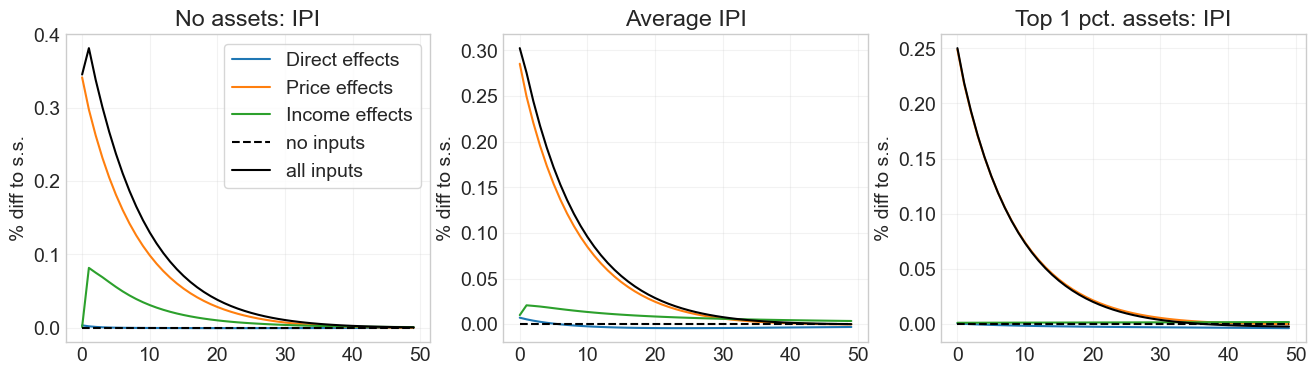

In [67]:
par.jump_istar = 0.0 # MP shock removed
par.jump_pm_N     = 0.01*ss.Q # cost push shock
T_max = 50
model.find_transition_path(do_print=False) #all

fig = plt.figure(figsize=(16,4),dpi=100)
### FIRST THE POOR WITHOUT ASSETS ### 

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(1,3,1)
i_color = 0
for use_inputs in [['Direct effects','r'],['Price effects','Q','P','p_L','p_N'],['Income effects','N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'{use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('No assets: IPI')        
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

### AVERAGE ###

Dbeg = ss.Dbeg.copy()
ax = fig.add_subplot(1,3,2)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_poor.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Average IPI')        
ax.set_ylabel('% diff to s.s.')

### WEALTHIEST ###
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

ax = fig.add_subplot(1,3,3)
i_color = 0
for use_inputs in [['r'],['Q','P','p_L','p_N'],['N','w_N','d_N','d_L','tau'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
    path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=use_inputs) 
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
    ax.plot((path_alt_rich.P_hh[0,:50]-path_alt_ss.P_hh[0,:50])/path_alt_ss.P_hh[0,:50]*100,ls=ls,color=color,label=label);
ax.set_title('Top 1 pct. assets: IPI')        
ax.set_ylabel('% diff to s.s.')
#ax.legend(frameon=True);



## Monetary Policy experiements

### varnames ###


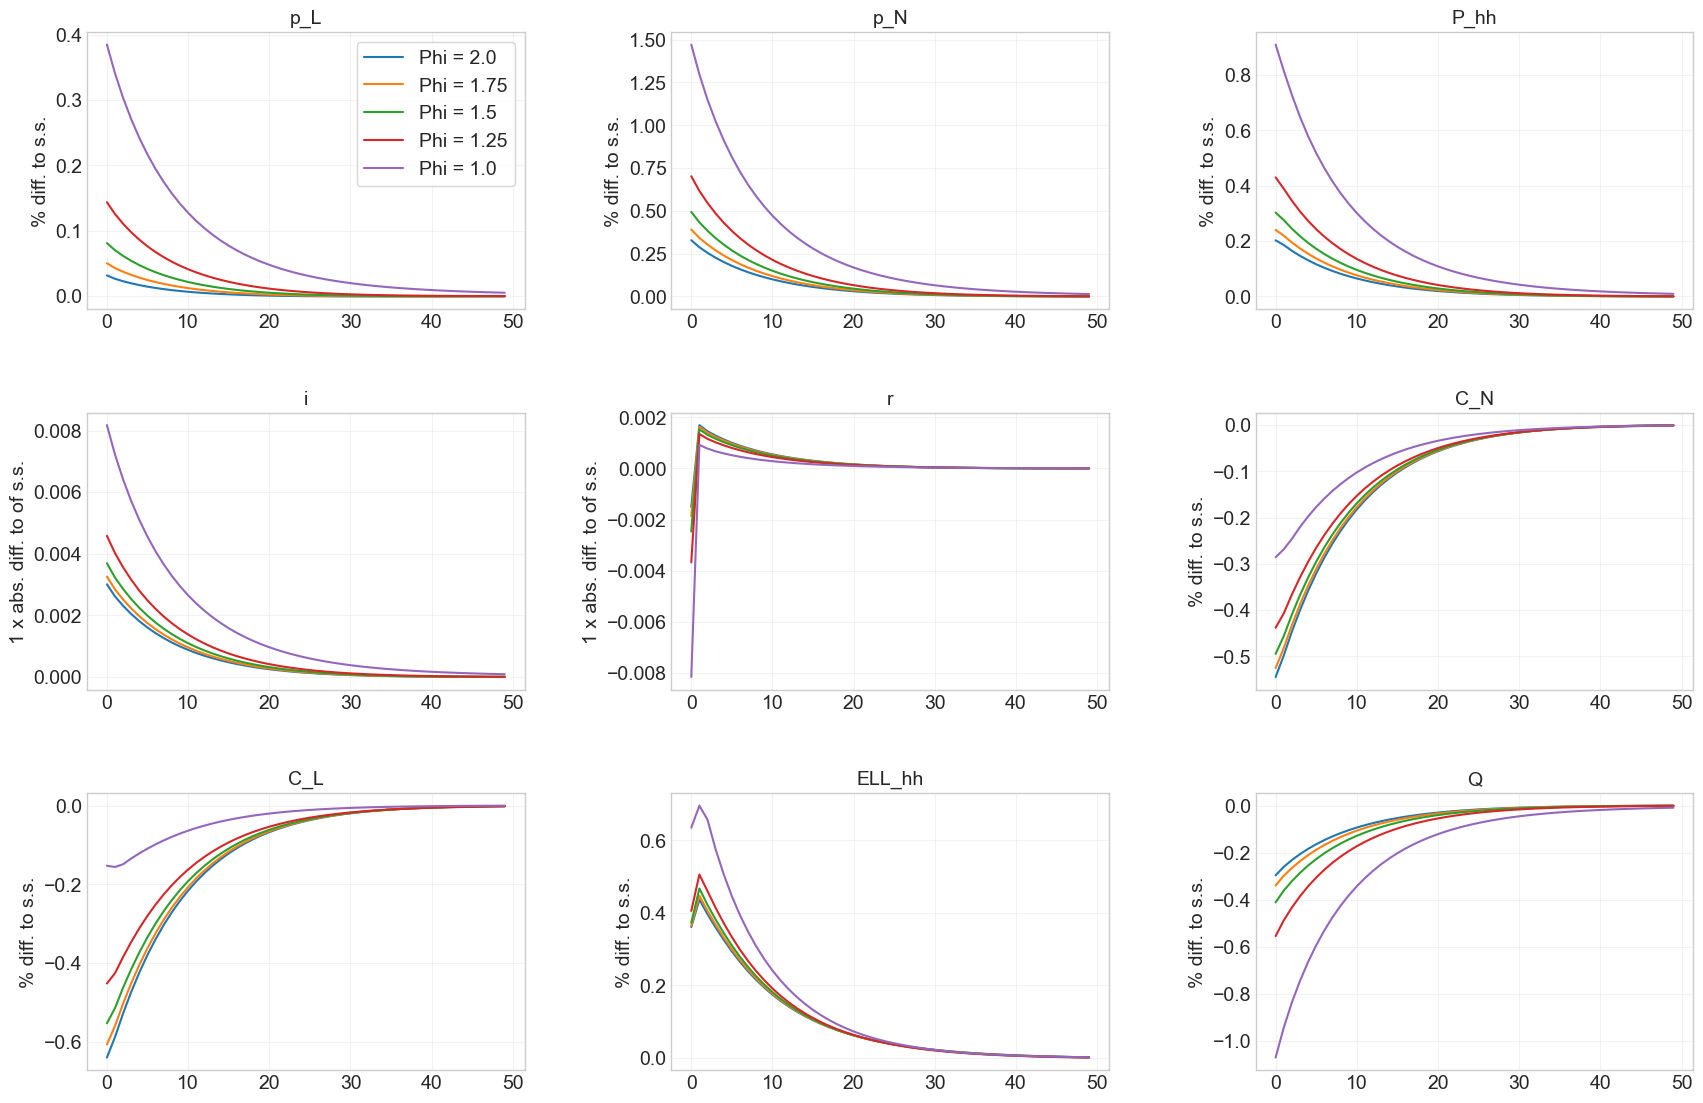

In [68]:
#Ensure baseline model has push shock
par.jump_istar = 0.00 # Monetary policy shock reset
par.jump_pm_N     = 0.01*ss.Q # cost push shock
model.find_transition_path(do_print=False) #all


model_one = model.copy()
model_one.par.phi = 2.0
model_one.par.jump_pm_N     = par.jump_pm_N # cost push shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_one.find_ss()
model_one.compute_jacs()
model_one.find_transition_path()


model_two = model.copy()
model_two.par.phi = 1.75
model_two.par.jump_pm_N     = par.jump_pm_N # cost push shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_two.find_ss()
model_two.compute_jacs()
model_two.find_transition_path()


model_three = model.copy()
model_three.par.phi = 1.25
model_three.par.jump_pm_N     = par.jump_pm_N # cost push shock
#model_three.par.jump_istar = 0.0025 # Monetary policy shock reset
model_three.find_ss()
model_three.compute_jacs()
model_three.find_transition_path()


model_four = model.copy()
model_four.par.phi = 1.00
model_four.par.jump_pm_N     = par.jump_pm_N # cost push shock
#model_four.par.jump_istar = 0.0025 # Monetary policy shock reset
model_four.find_ss()
model_four.compute_jacs()
model_four.find_transition_path()



paths = ['p_L','p_N','P_hh','i','r','C_N','C_L','ELL_hh','Q'] #Show all graphs
model.compare_IRFs([model_one,model_two,model,model_three,model_four],['Phi = 2.0','Phi = 1.75','Phi = 1.5','Phi = 1.25','Phi = 1.0'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=3)

Nondecomposed behavior for a subset of households. Here consumption for those with zero assets contra max assets.

In [69]:
T_max = 50

## 1 - consumption responses for no asset holders    

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
#Dbeg[:,:,:] = 0.0 # zero every else than in last 50 asset grid points
Dbeg /= np.sum(Dbeg) # re-normalize
path_alt_poor_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_poor_ss_one = model_one.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_poor_ss_two = model_two.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_poor_ss_three = model_three.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_poor_ss_four = model_four.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    

path_alt_poor = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_poor_one = model_one.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_poor_two = model_two.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_poor_three = model_three.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_poor_four = model_four.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 



### 2 - Consumption responses for top 1 pct. asset holders

Dbeg = ss.Dbeg.copy()
Dbeg[:,:,:480] = 0.0 # zero every else than in last asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_rich_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_rich_ss_one = model_one.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_rich_ss_two = model_two.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_rich_ss_three = model_three.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_rich_ss_four = model_four.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    

path_alt_rich = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_rich_one = model_one.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_rich_two = model_two.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_rich_three = model_three.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_rich_four = model_four.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 


### Average responses


Dbeg = ss.Dbeg.copy() #reset dbeg value

path_alt_average_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_average_ss_one = model_one.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_average_ss_two = model_two.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_average_ss_three = model_three.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt_average_ss_four = model_four.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    

path_alt_average = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_average_one = model_one.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_average_two = model_two.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_average_three = model_three.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 
path_alt_average_four = model_four.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 



MemoryError: Unable to allocate 9.54 MiB for an array with shape (2500, 500) and data type float64

In [ ]:
T_max = 50

fig = plt.figure(figsize=(3*6,3*4),dpi=100)

ax = fig.add_subplot(3,3,1)
ax.set_title('Consumption - response poor')
ax.plot((path_alt_poor.C_hh[0,:50]-path_alt_poor_ss.C_hh[0,:50])/path_alt_poor_ss.C_hh[0,:50]*100,label='Phi = 1.5 (baseline)');
ax.plot((path_alt_poor_one.C_hh[0,:50]-path_alt_poor_ss_one.C_hh[0,:50])/path_alt_poor_ss_one.C_hh[0,:50]*100,label='phi = 2.0');
ax.plot((path_alt_poor_two.C_hh[0,:50]-path_alt_poor_ss_two.C_hh[0,:50])/path_alt_poor_ss_two.C_hh[0,:50]*100,label='phi = 1.75');
ax.plot((path_alt_poor_three.C_hh[0,:50]-path_alt_poor_ss_three.C_hh[0,:50])/path_alt_poor_ss_three.C_hh[0,:50]*100,label='phi = 1.25');
ax.plot((path_alt_poor_four.C_hh[0,:50]-path_alt_poor_ss_four.C_hh[0,:50])/path_alt_poor_ss_four.C_hh[0,:50]*100,label='phi = 1.00');
ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True);

ax = fig.add_subplot(3,3,2)
ax.set_title('Labor - response poor')
ax.plot((path_alt_poor.ELL_hh[0,:50]-path_alt_poor_ss.ELL_hh[0,:50])/path_alt_poor_ss.ELL_hh[0,:50]*100);
ax.plot((path_alt_poor_one.ELL_hh[0,:50]-path_alt_poor_ss_one.ELL_hh[0,:50])/path_alt_poor_ss_one.ELL_hh[0,:50]*100);
ax.plot((path_alt_poor_two.ELL_hh[0,:50]-path_alt_poor_ss_two.ELL_hh[0,:50])/path_alt_poor_ss_two.ELL_hh[0,:50]*100);
ax.plot((path_alt_poor_three.ELL_hh[0,:50]-path_alt_poor_ss_three.ELL_hh[0,:50])/path_alt_poor_ss_three.ELL_hh[0,:50]*100);
ax.plot((path_alt_poor_four.ELL_hh[0,:50]-path_alt_poor_ss_four.ELL_hh[0,:50])/path_alt_poor_ss_four.ELL_hh[0,:50]*100);


ax = fig.add_subplot(3,3,3)
ax.set_title('Utility - response poor')
ax.plot((path_alt_poor.U_hh[0,:50]-path_alt_poor_ss.U_hh[0,:50])/path_alt_poor_ss.U_hh[0,:50]*-100);
ax.plot((path_alt_poor_one.U_hh[0,:50]-path_alt_poor_ss_one.U_hh[0,:50])/path_alt_poor_ss_one.U_hh[0,:50]*-100);
ax.plot((path_alt_poor_two.U_hh[0,:50]-path_alt_poor_ss_two.U_hh[0,:50])/path_alt_poor_ss_two.U_hh[0,:50]*-100);
ax.plot((path_alt_poor_three.U_hh[0,:50]-path_alt_poor_ss_three.U_hh[0,:50])/path_alt_poor_ss_three.U_hh[0,:50]*-100);
ax.plot((path_alt_poor_four.U_hh[0,:50]-path_alt_poor_ss_four.U_hh[0,:50])/path_alt_poor_ss_four.U_hh[0,:50]*-100);

ax = fig.add_subplot(3,3,4)
ax.set_title('Consumption - response rich')
ax.plot((path_alt_rich.C_hh[0,:50]-path_alt_rich_ss.C_hh[0,:50])/path_alt_rich_ss.C_hh[0,:50]*100);
ax.plot((path_alt_rich_one.C_hh[0,:50]-path_alt_rich_ss_one.C_hh[0,:50])/path_alt_rich_ss_one.C_hh[0,:50]*100);
ax.plot((path_alt_rich_two.C_hh[0,:50]-path_alt_rich_ss_two.C_hh[0,:50])/path_alt_rich_ss_two.C_hh[0,:50]*100);
ax.plot((path_alt_rich_three.C_hh[0,:50]-path_alt_rich_ss_three.C_hh[0,:50])/path_alt_rich_ss_three.C_hh[0,:50]*100);
ax.plot((path_alt_rich_four.C_hh[0,:50]-path_alt_rich_ss_four.C_hh[0,:50])/path_alt_rich_ss_four.C_hh[0,:50]*100);

ax = fig.add_subplot(3,3,5)
ax.set_title('Labor - response rich')
ax.plot((path_alt_rich.ELL_hh[0,:50]-path_alt_rich_ss.ELL_hh[0,:50])/path_alt_rich_ss.ELL_hh[0,:50]*100);
ax.plot((path_alt_rich_one.ELL_hh[0,:50]-path_alt_rich_ss_one.ELL_hh[0,:50])/path_alt_rich_ss_one.ELL_hh[0,:50]*100);
ax.plot((path_alt_rich_two.ELL_hh[0,:50]-path_alt_rich_ss_two.ELL_hh[0,:50])/path_alt_rich_ss_two.ELL_hh[0,:50]*100);
ax.plot((path_alt_rich_three.ELL_hh[0,:50]-path_alt_rich_ss_three.ELL_hh[0,:50])/path_alt_rich_ss_three.ELL_hh[0,:50]*100);
ax.plot((path_alt_rich_four.ELL_hh[0,:50]-path_alt_rich_ss_four.ELL_hh[0,:50])/path_alt_rich_ss_four.ELL_hh[0,:50]*100);

ax = fig.add_subplot(3,3,6)
ax.set_title('Utility - response rich')
ax.plot((path_alt_rich.U_hh[0,:50]-path_alt_rich_ss.U_hh[0,:50])/path_alt_rich_ss.U_hh[0,:50]*-100);
ax.plot((path_alt_rich_one.U_hh[0,:50]-path_alt_rich_ss_one.U_hh[0,:50])/path_alt_rich_ss_one.U_hh[0,:50]*-100);
ax.plot((path_alt_rich_two.U_hh[0,:50]-path_alt_rich_ss_two.U_hh[0,:50])/path_alt_rich_ss_two.U_hh[0,:50]*-100);
ax.plot((path_alt_rich_three.U_hh[0,:50]-path_alt_rich_ss_three.U_hh[0,:50])/path_alt_rich_ss_three.U_hh[0,:50]*-100);
ax.plot((path_alt_rich_four.U_hh[0,:50]-path_alt_rich_ss_four.U_hh[0,:50])/path_alt_rich_ss_four.U_hh[0,:50]*-100);

ax = fig.add_subplot(3,3,7)
ax.set_title('Consumption response average')
ax.plot((path_alt_average.C_hh[0,:50]-path_alt_average_ss.C_hh[0,:50])/path_alt_average_ss.C_hh[0,:50]*100);
ax.plot((path_alt_average_one.C_hh[0,:50]-path_alt_average_ss_one.C_hh[0,:50])/path_alt_average_ss_one.C_hh[0,:50]*100);
ax.plot((path_alt_average_two.C_hh[0,:50]-path_alt_average_ss_two.C_hh[0,:50])/path_alt_average_ss_two.C_hh[0,:50]*100);
ax.plot((path_alt_average_three.C_hh[0,:50]-path_alt_average_ss_three.C_hh[0,:50])/path_alt_average_ss_three.C_hh[0,:50]*100);
ax.plot((path_alt_average_four.C_hh[0,:50]-path_alt_average_ss_four.C_hh[0,:50])/path_alt_average_ss_four.C_hh[0,:50]*100);


ax = fig.add_subplot(3,3,8)
ax.set_title('Labor - response average')
ax.plot((path_alt_average.ELL_hh[0,:50]-path_alt_average_ss.ELL_hh[0,:50])/path_alt_average_ss.ELL_hh[0,:50]*100);
ax.plot((path_alt_average_one.ELL_hh[0,:50]-path_alt_average_ss_one.ELL_hh[0,:50])/path_alt_average_ss_one.ELL_hh[0,:50]*100);
ax.plot((path_alt_average_two.ELL_hh[0,:50]-path_alt_average_ss_two.ELL_hh[0,:50])/path_alt_average_ss_two.ELL_hh[0,:50]*100);
ax.plot((path_alt_average_three.ELL_hh[0,:50]-path_alt_average_ss_three.ELL_hh[0,:50])/path_alt_average_ss_three.ELL_hh[0,:50]*100);
ax.plot((path_alt_average_four.ELL_hh[0,:50]-path_alt_average_ss_four.ELL_hh[0,:50])/path_alt_average_ss_four.ELL_hh[0,:50]*100);

ax = fig.add_subplot(3,3,9)
ax.set_title('Utility - response average')
ax.plot((path_alt_average.U_hh[0,:50]-path_alt_average_ss.U_hh[0,:50])/path_alt_average_ss.U_hh[0,:50]*-100);
ax.plot((path_alt_average_one.U_hh[0,:50]-path_alt_average_ss_one.U_hh[0,:50])/path_alt_average_ss_one.U_hh[0,:50]*-100);
ax.plot((path_alt_average_two.U_hh[0,:50]-path_alt_average_ss_two.U_hh[0,:50])/path_alt_average_ss_two.U_hh[0,:50]*-100);
ax.plot((path_alt_average_three.U_hh[0,:50]-path_alt_average_ss_three.U_hh[0,:50])/path_alt_average_ss_three.U_hh[0,:50]*-100);
ax.plot((path_alt_average_four.U_hh[0,:50]-path_alt_average_ss_four.U_hh[0,:50])/path_alt_average_ss_four.U_hh[0,:50]*-100);

## Find effect of parameter change

In [ ]:
#Ensure baseline model has push shock
par.jump_istar = 0.00 # Monetary policy shock reset
par.jump_pm_N     = 0.01*ss.Q # cost push shock
model.find_transition_path(do_print=False) #all

#CD loading checks
model_one = model.copy()
model_one.par.alpha_N = 0.5
model_one.par.alpha_L = 0.5
model_one.par.jump_pm_N     = par.jump_pm_N # cost push shock
model_one.par.jump_istar     = par.jump_istar # Monetary policy shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_one.find_ss()
model_one.compute_jacs()
model_one.find_transition_path()

#Mark-up checks
model_two = model.copy()
model_two.par.mu_L = 1.5
model_two.par.mu_N = 1.5
model_two.par.jump_pm_N     = par.jump_pm_N # cost push shock
model_two.par.jump_istar     = par.jump_istar # Monetary policy shock
#model_two.par.jump_istar = 0.0025 # Monetary policy shock reset
model_two.find_ss()
model_two.compute_jacs()
model_two.find_transition_path()

#Price rigidity checks
model_three = model.copy()
model_three.par.kappa_L = 0.125
model_three.par.kappa_N = 0.125
model_three.par.jump_pm_N     =par.jump_pm_N # cost push shock
model_three.par.jump_istar     = par.jump_istar # Monetary policy shock
#model_three.par.jump_istar = 0.0025 # Monetary policy shock reset
model_three.find_ss()
model_three.compute_jacs()
model_three.find_transition_path()

#Substitution elasticities check
model_four = model.copy()
model_four.par.gamma_L = 0.375
model_four.par.gamma_N = 0.375
model_four.par.jump_pm_N     = par.jump_pm_N # cost push shock
model_four.par.jump_istar     = par.jump_istar # Monetary policy shock
#model_four.par.jump_istar = 0.0025 # Monetary policy shock reset
model_four.find_ss()
model_four.compute_jacs()
model_four.find_transition_path()


paths = ['pm_N','P_hh','p_L','p_N','Q','i','r','tau','C_N','C_L','N_N','N_L','M_N','M_L','w_N'] #Show all graphs
model.compare_IRFs([model,model_one,model_two,model_three,model_four],['baseline','alpha_s = 0.5','mu_$s$ = 1.5','kappa_s = 0.125','gamma_s = 0.375'],paths,lvl_value,do_shocks=False,do_targets=False,T_max=50,ncols=3)

# Step 3b: Find linearized IRFs

In [ ]:
model.find_IRFs(do_print=True)

In [ ]:
paths = ['Y','N','N_hh','M_N','M_L','C_N_hh','C_L_hh','C','Q','tau','d_L','d_N','P_hh']
model.show_IRFs(paths,T_max=20,ncols=4,do_linear=True)

# Step 4. Simulation

In [ ]:
np.random.seed(1917)
model.simulate(do_print=True)

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('Nominal interest rate, i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('Inflation, pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('Real interest rate, r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('Aggregate consumption, C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()